# 0.0. IMPORTS

In [188]:
import pandas as pd
import numpy as np
import inflection
import math
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image
from scipy.stats import chi2_contingency

## 0.1. Helper Functions

In [187]:
def cramer_v(x,y):
    cm = pd.crosstab(x, y).to_numpy()
    chi2 = chi2_contingency(cm)[0]
    n = cm.sum()
    r, k = cm.shape
    #corrigindo o bias
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt((chi2corr/n) / min(kcorr-1, rcorr-1))


def jupyter_settings():    
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


/home/analogicallergy/.pyenv/versions/3.8.0/envs/rossmann/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['cm']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2. Loading data

In [3]:
df_sales_raw = pd.read_csv('../data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../data/store.csv', low_memory=False)

#merging the two datasets on store_id

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [4]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
872320,61,5,2013-05-10,5115,645,1,0,0,0,a,c,350.0,12.0,2007.0,1,1.0,2012.0,"Jan,Apr,Jul,Oct"


# 1.0. DESCRIÇÃO DOS DADOS

## 1.1. Rename Columns


In [5]:
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [6]:
# copiando o dataset original
df1 = df_raw.copy()

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

#definindo a função snakecase com lambda
snakecase = lambda x: inflection.underscore(x) 

# mapear as colunas antigas, fazendo com que a cada coluna seja aplicada a funcao snakecase 
# e retornando uma lista de novas colunas
cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

In [8]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimension

In [9]:
print('Number of rows {}'.format(df1.shape[0]))
print('Number of columns {} '.format(df1.shape[1]))

Number of rows 1017209
Number of columns 18 


## 1.3. Data Types

In [10]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [11]:
#veja que a data e um object e nao um datetime
#como mudar

df1['date'] = pd.to_datetime(df1['date'])

In [12]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check N/A

In [13]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout N/A


In [14]:
#competition_distance - a distancia do competidor mais proximo (ou nao tem competidor ou e muito longe pra competir)
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)
# aplique em todas as linhas competition_distance 200000 se for um NaN, senao aplique o valor existente  

#competition_open_since_month - competidor mais proximo aberto
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year   
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week   
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)


In [15]:

#promo_interval
month_map = {1: 'Jan',2: 'Feb',3: 'Mar',4: 'Apr',5: 'May',6: 'Jun',7: 'Jul',8: 'Aug',9: 'Sep',10: 'Oct',11: 'Nov',12: 'Dec'}
df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)

#eh promocao quando a promo2 coincide com a date
df1['is_promo'] =  df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)


In [16]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [17]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [18]:
df1['competition_open_since_month']= df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year']= df1['competition_open_since_year'].astype(int)
df1['promo2_since_week']= df1['promo2_since_week'].astype(int)
df1['promo2_since_year']= df1['promo2_since_year'].astype(int)


In [19]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistics

In [20]:
# filtrar atributos numericos do dataset
num_attributes = df1.select_dtypes(include= ['int32', 'int64', 'float32', 'float64' ])
cat_attributes = df1.select_dtypes(exclude=['int32', 'int64', 'float32', 'float64', 'datetime64[ns]'])

In [21]:
num_attributes.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1,5,5263,555,1,1,1,1270.0,9,2008,0,31,2015,0
1,2,5,6064,625,1,1,1,570.0,11,2007,1,13,2010,1
2,3,5,8314,821,1,1,1,14130.0,12,2006,1,14,2011,1
3,4,5,13995,1498,1,1,1,620.0,9,2009,0,31,2015,0
4,5,5,4822,559,1,1,1,29910.0,4,2015,0,31,2015,0


In [22]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


### 1.7.1. Numerical Statistics

In [23]:
#Medidas de Tendencia Central
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Medidas de Dispersao
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenando os resultados

metrics = pd.concat([d2, d3, d4, ct1,ct2, d1, d5, d6]).T.reset_index()
metrics.columns = ['attributes', 'min','max','range', 'mean', 'median','std','skew','kurtosis']
metrics


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2. Categorical Statistics

In [24]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

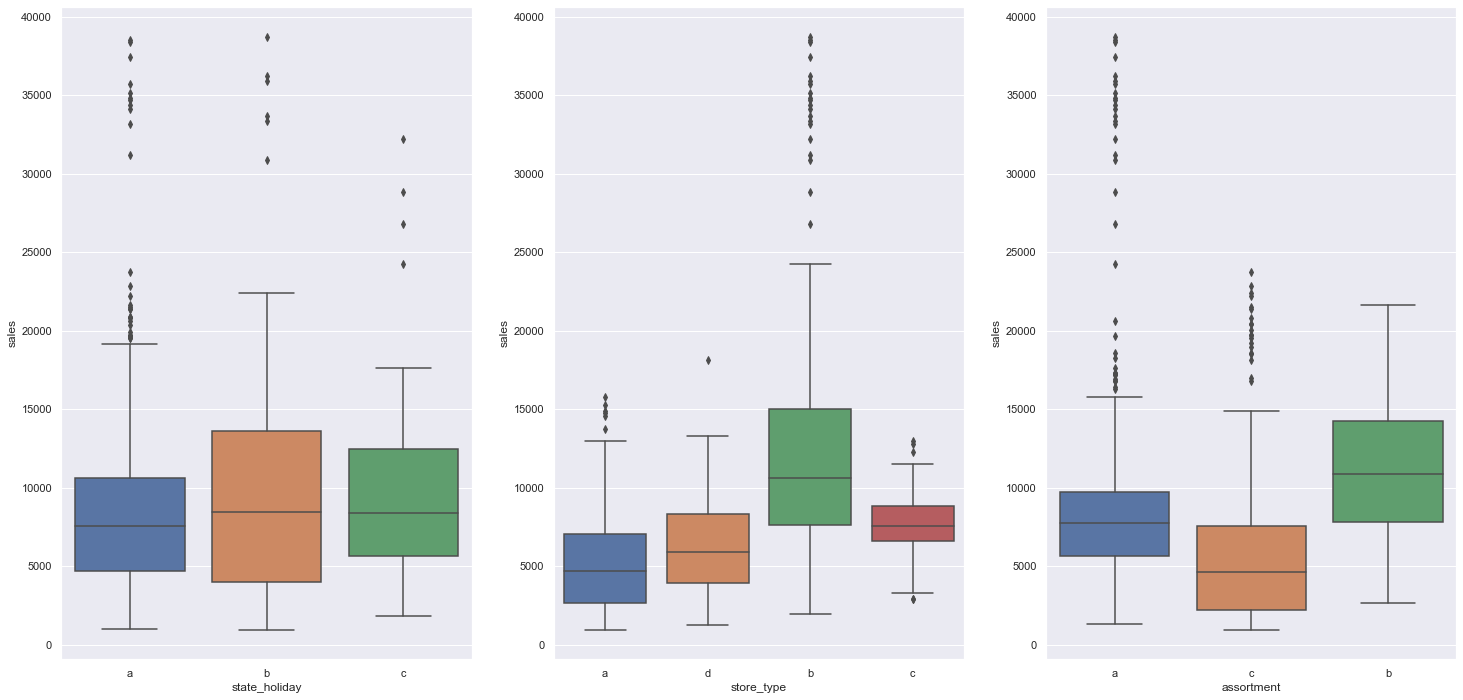

In [25]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] != 0)]
plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)
plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1)
plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2.0. Feature Engineering

In [26]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipóteses

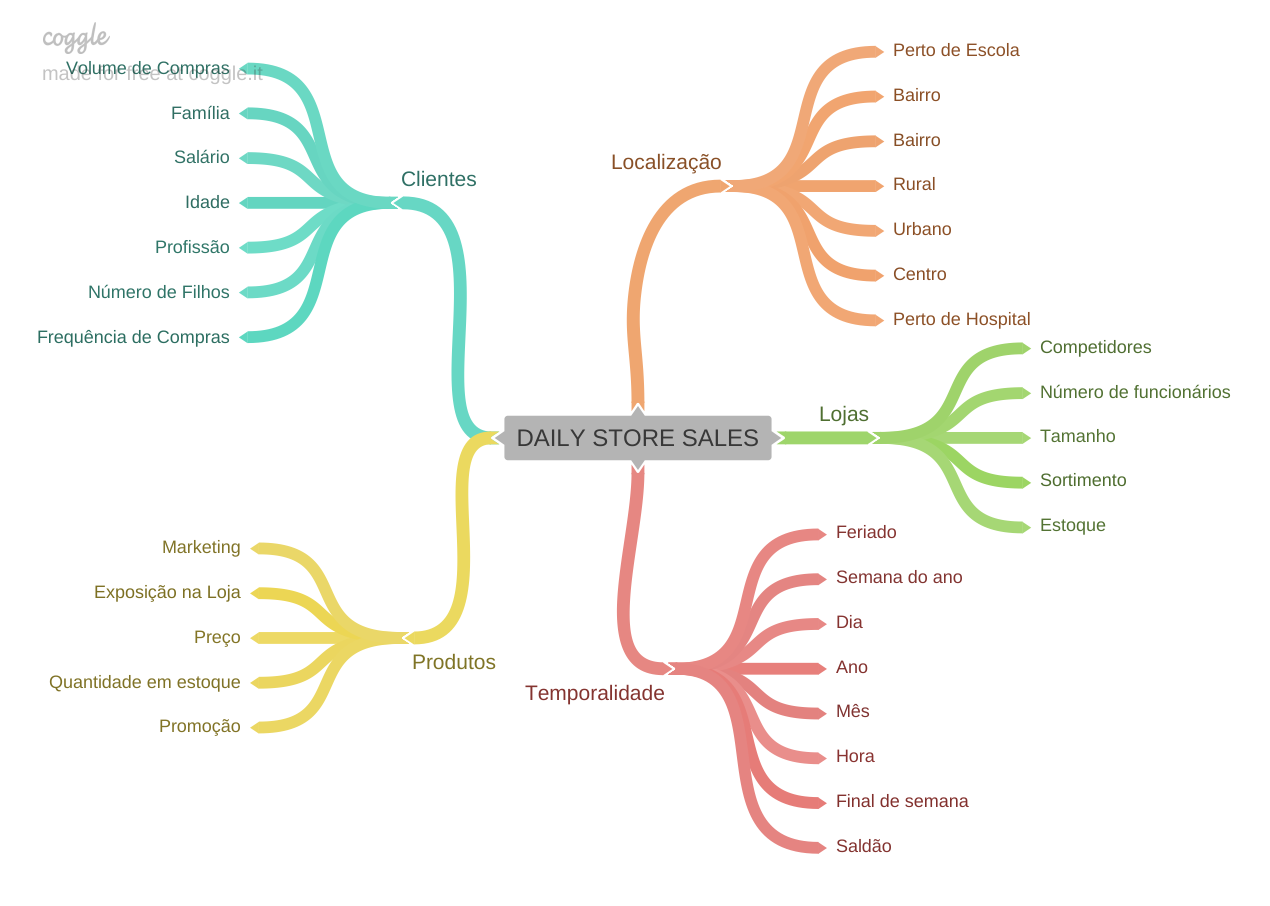

In [27]:
Image('../img/mindmap_hypothesis.png')

## 2.2. Criação das Hipóteses


### 2.2.1. Hipóteses Loja

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores a mais tempo deveriam vender menos.



### 2.2.2. Hipóteses Produto


**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas que expõe mais os produtos nas vitrines deveriam vender mais.

**3.** Lojas que tem preços menores nos produtos deveriam vender mais.

**4.** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.


### 2.2.3. Hipóteses Tempo


**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.





## 2.3. Lista Final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3 .** Lojas com competidores a mais tempo deveriam vender menos.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.


## 2.4. Feature Engineering

In [28]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month
#day
df2['day'] = df2['date'].dt.day
#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear
#year week
# concatenara o ano da data mais a semana do ano
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#competition since
#precisaremos compor a data atraves da uniao de duas colunas

df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
#tempo que a competicao comecou em meses - /30 me da a quantidade de meses
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) /30).apply(lambda x: x.days).astype(int)


#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-'+df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x+'-1', '%Y-%W-%w') - datetime.timedelta(days=7))
#tempo da promocao ativa em semanas

df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')
#state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

<ipython-input-28-43e5c0b181fb>:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


In [29]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. Filtragem de Variáveis

In [72]:
df33 = df2.copy()

In [30]:
#filtrar - deve levar em conta as restrições do negócio

#copia do dataset
df3 = df2.copy()

## 3.1. Filtragem das linhas

In [31]:
df3 = df3[(df3['open'] != 0 )& (df3['sales'] > 0)]


## 3.2. Seleção das colunas

In [32]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [33]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. Análise Exploratória de Dados


In [34]:
df4 = df3.copy()

In [35]:
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 4.1. Análise Univariada

### 4.1.1. Response Variables

/home/analogicallergy/.pyenv/versions/3.8.0/envs/rossmann/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

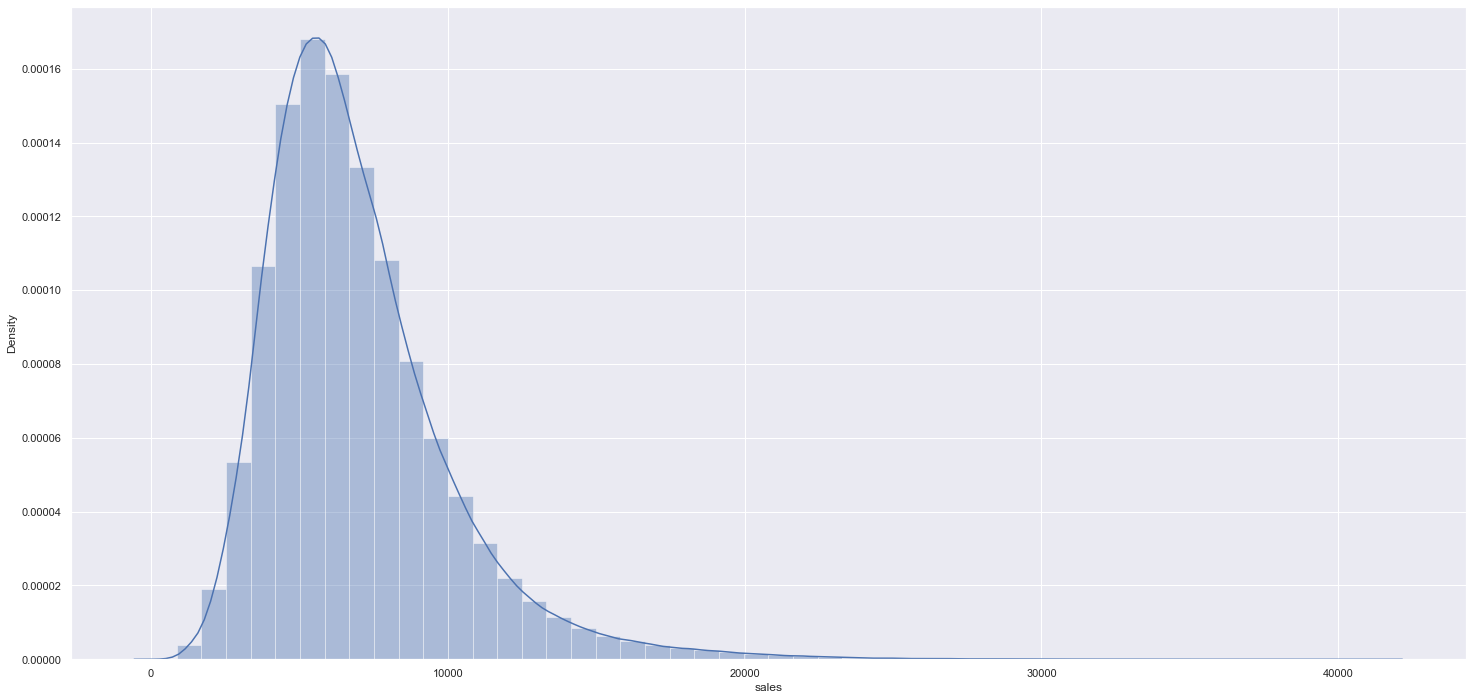

In [36]:
sns.distplot(df4['sales'])

/home/analogicallergy/.pyenv/versions/3.8.0/envs/rossmann/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales'>

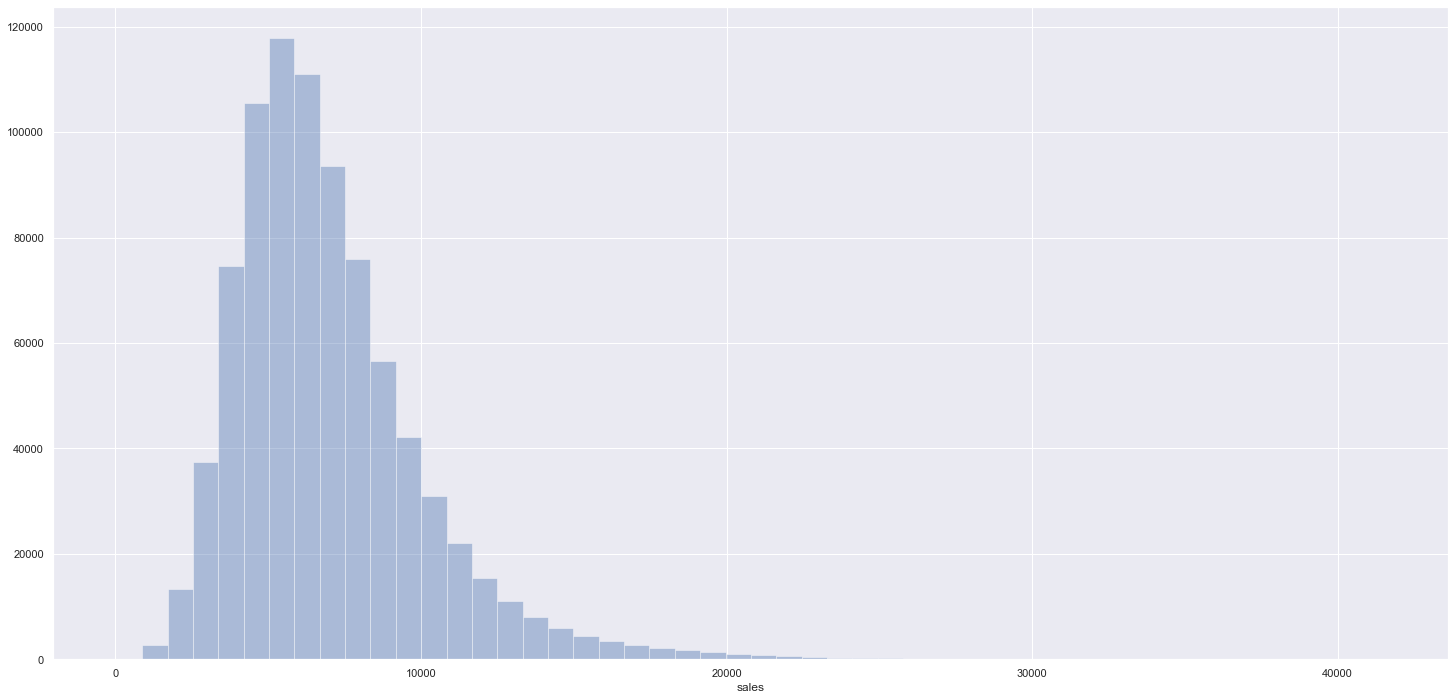

In [37]:
sns.distplot(df4['sales'], kde=False)

### 4.1.2 Numerical Variables

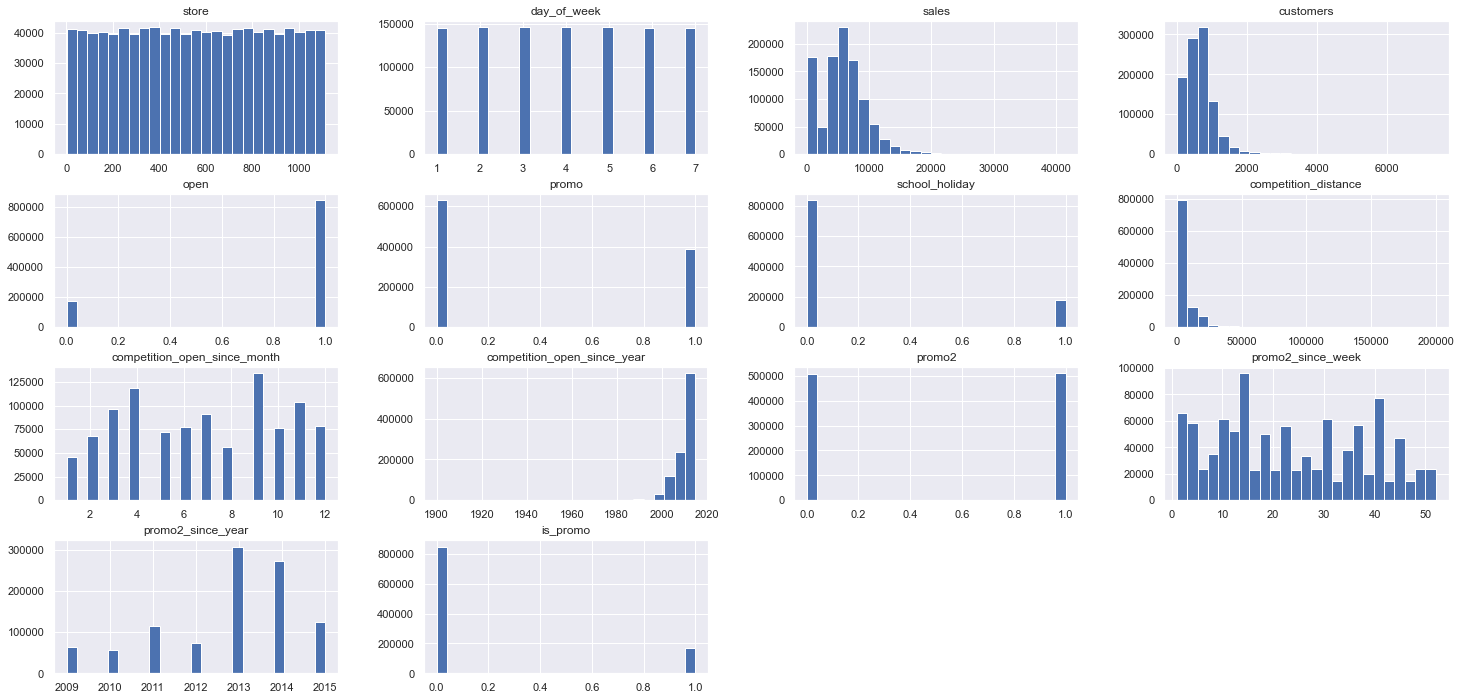

In [38]:
num_attributes.hist(bins=25);

### 4.1.3. Categorical Variables

In [39]:
qtd = df4['state_holiday'].drop_duplicates()
qtd

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

/home/analogicallergy/.pyenv/versions/3.8.0/envs/rossmann/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='state_holiday', ylabel='count'>

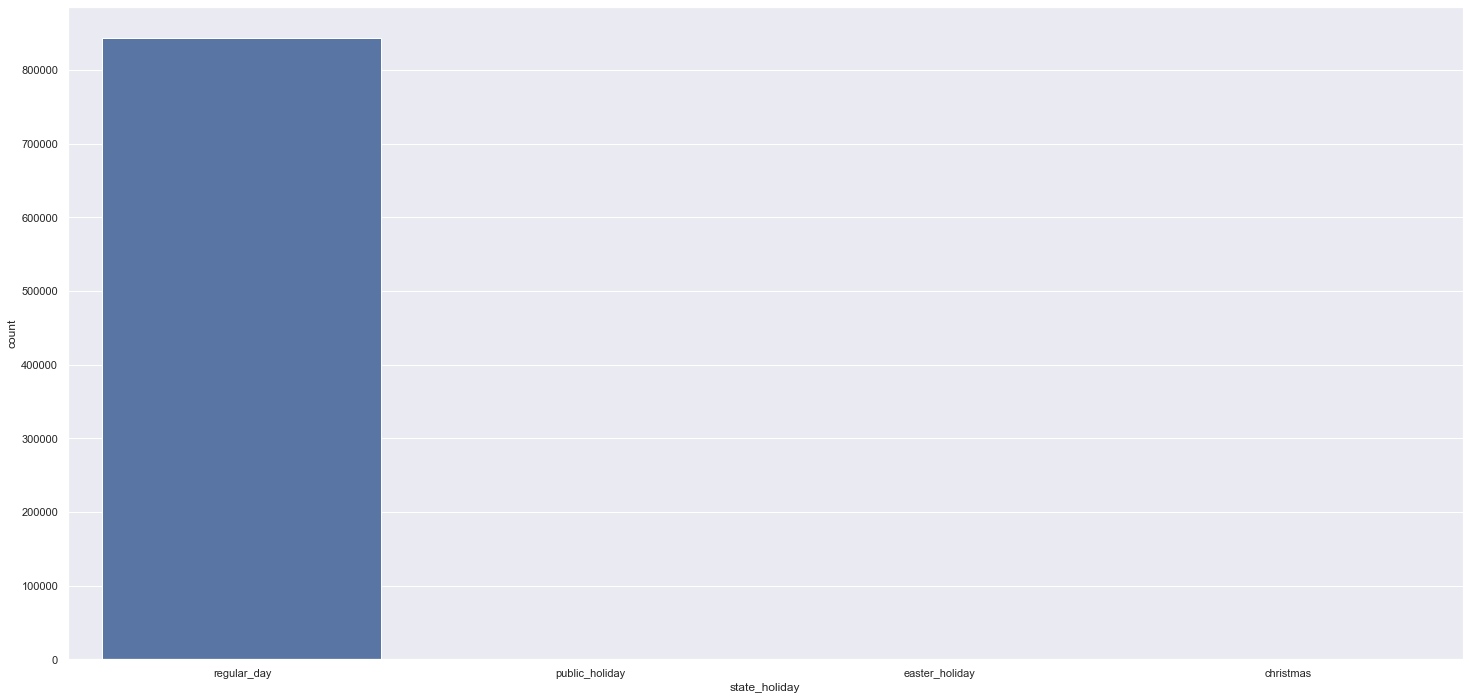

In [40]:
sns.countplot(df4[
    'state_holiday'
])

/home/analogicallergy/.pyenv/versions/3.8.0/envs/rossmann/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sales', ylabel='Density'>

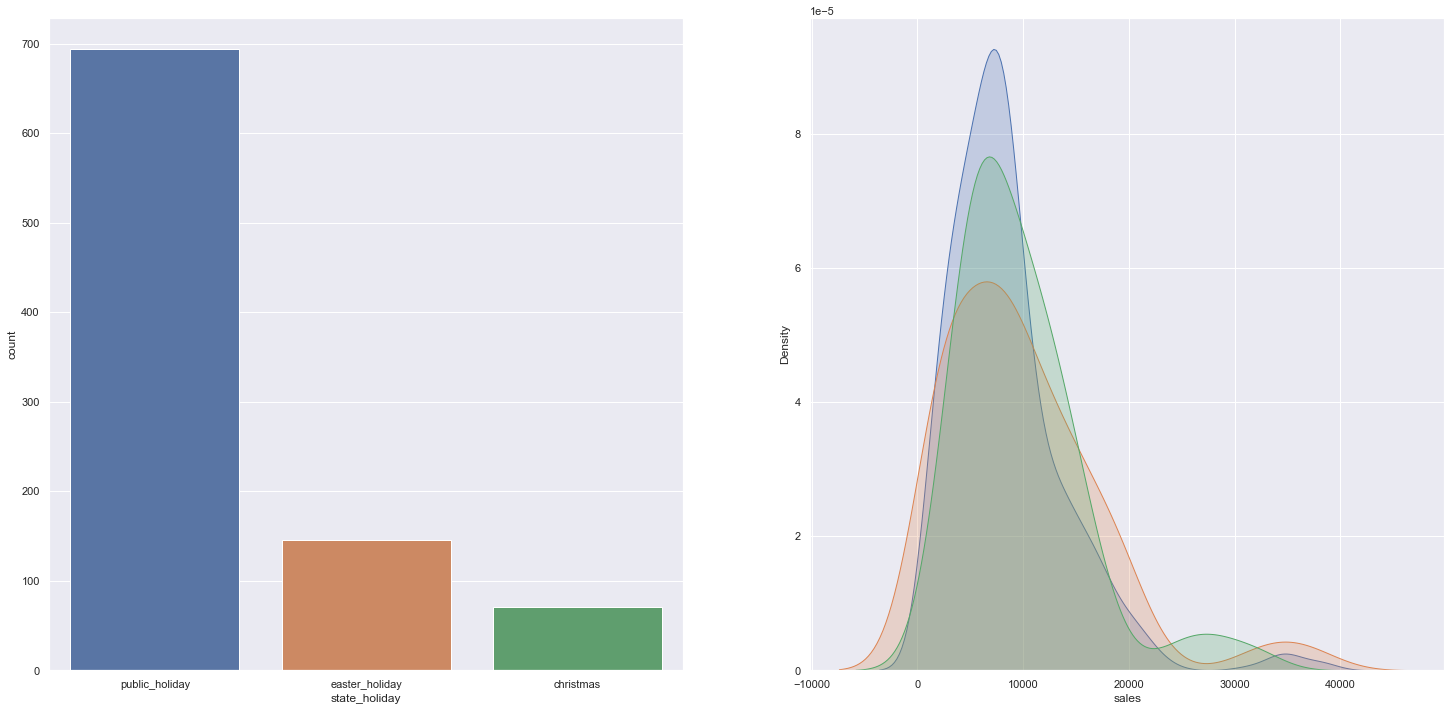

In [41]:
holidays = df4[df4['state_holiday'] != 'regular_day']
plt.subplot(1,2,1)

sns.countplot(holidays['state_holiday'])

plt.subplot(1,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

/home/analogicallergy/.pyenv/versions/3.8.0/envs/rossmann/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sales', ylabel='Density'>

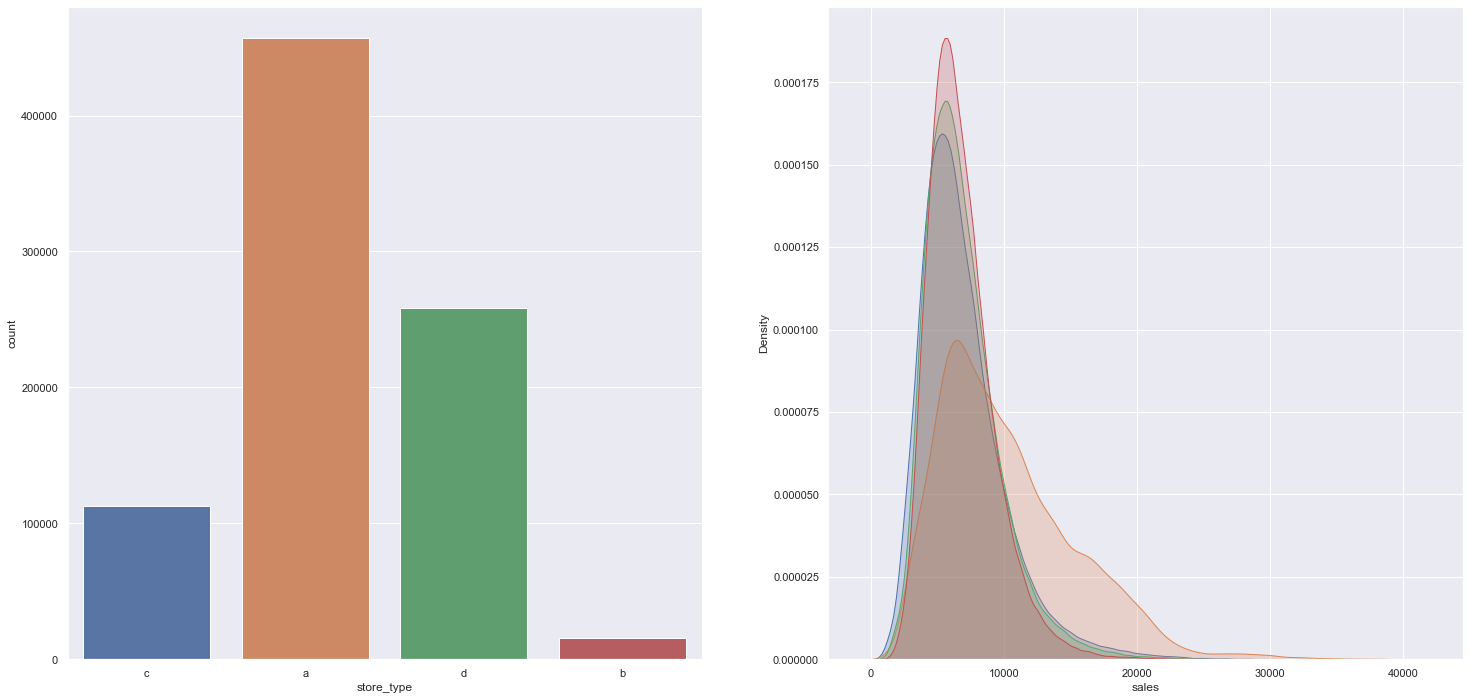

In [42]:
#store type

plt.subplot(1,2,1)

sns.countplot(df4['store_type'])

plt.subplot(1,2,2)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='A', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='B', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='C', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='D', shade=True)

In [43]:
#store type
df4['assortment'].unique()

array(['basic', 'extended', 'extra'], dtype=object)

/home/analogicallergy/.pyenv/versions/3.8.0/envs/rossmann/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sales', ylabel='Density'>

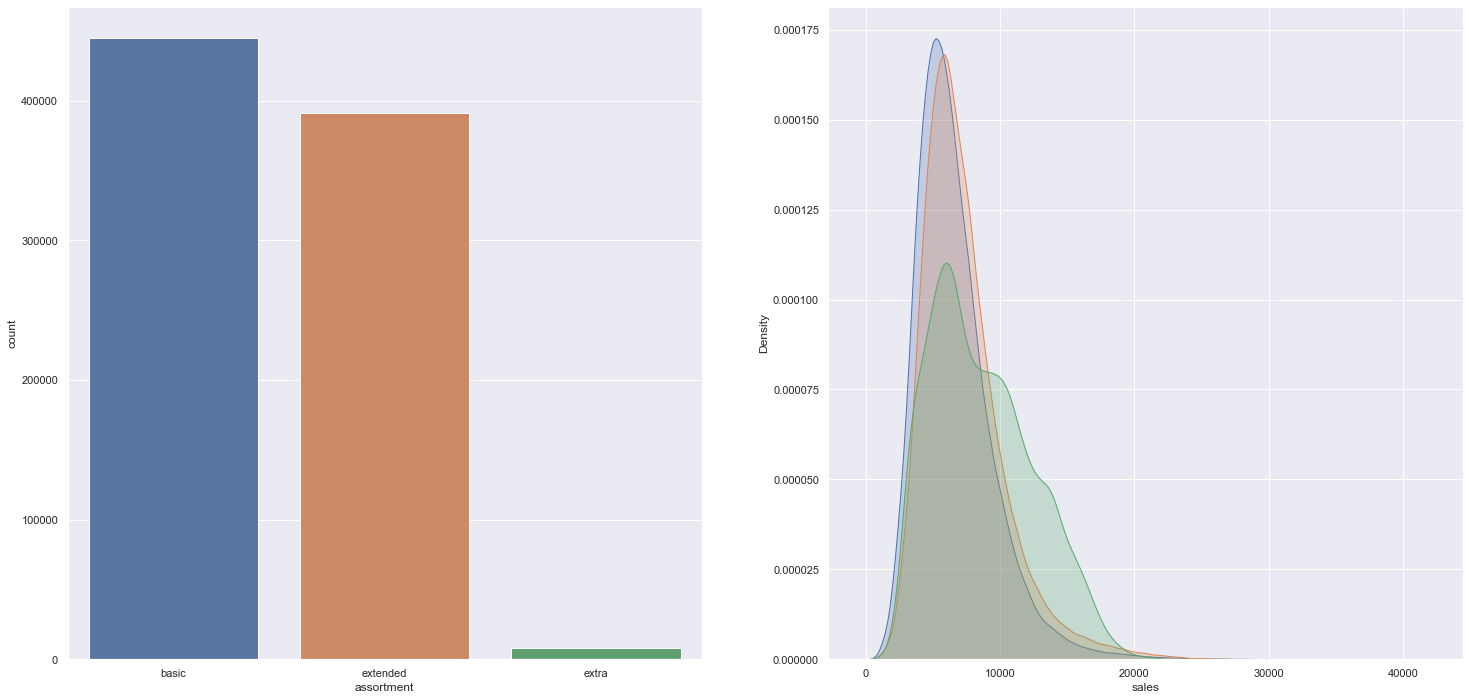

In [44]:
plt.subplot(1,2,1)

sns.countplot(df4['assortment'])

plt.subplot(1,2,2)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='Basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='Extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='Extra', shade=True)


## 4.2. Análise Bivariada

### **H1**. Lojas com maior sortimento deveriam vender mais



<AxesSubplot:xlabel='assortment', ylabel='sales'>

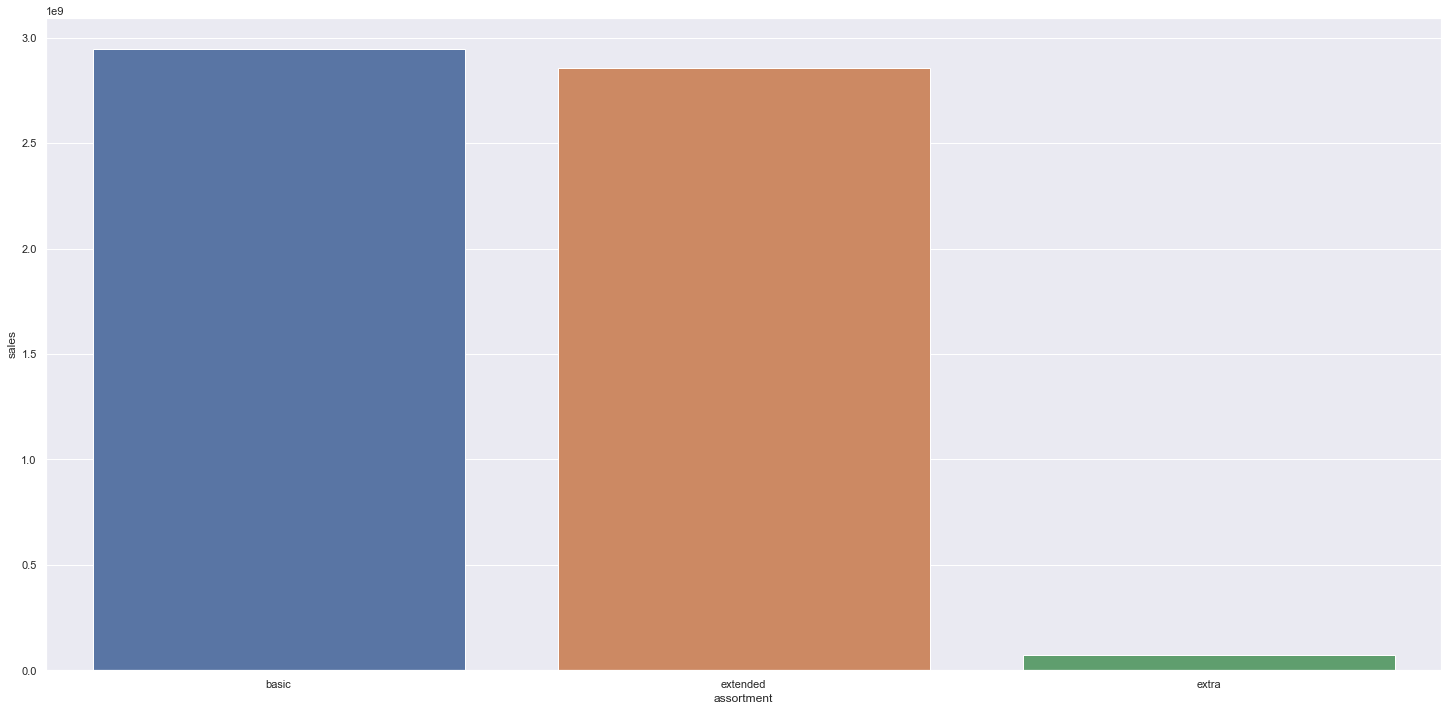

In [45]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1)

In [46]:
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
#aux2
aux2.head()

#pivot
aux3 = aux2.pivot(index='year_week', columns='assortment', values='sales')

In [47]:
aux3.head()

assortment,basic,extended,extra
year_week,,,
2013-00,13434262,12425669,269404
2013-01,26007250,22917693,350279
2013-02,17970974,16029584,377207
2013-03,24392076,21243431,404662
2013-04,19972891,18130077,363061


<AxesSubplot:xlabel='year_week'>

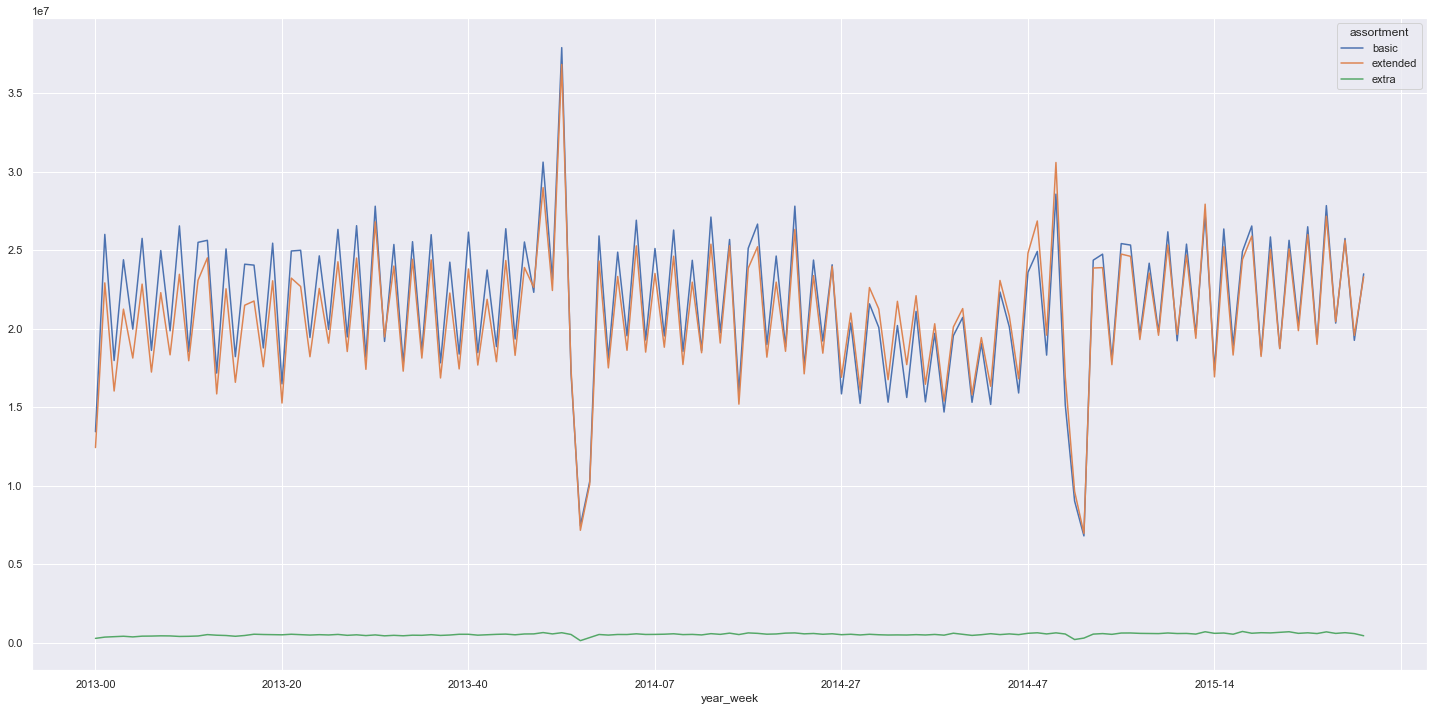

In [48]:
aux3.plot()

<AxesSubplot:xlabel='year_week'>

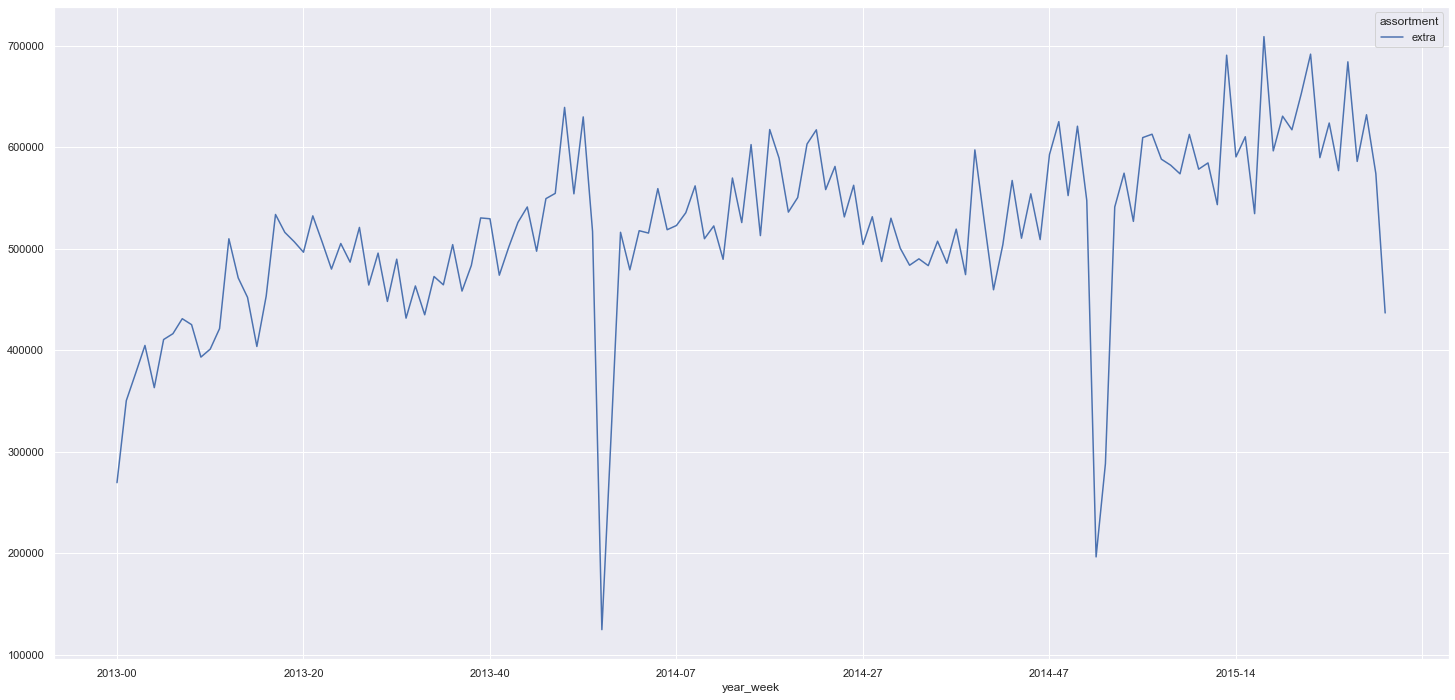

In [49]:
#verificando a escala de valores do assortment extra
aux4 = aux2[aux2['assortment'] == 'extra']
aux4.pivot(index='year_week', columns='assortment', values='sales').plot()

#### Conclusão: Lojas com MAIOR SORTIMENTO vendem MENOS - FALSA

### H2. Lojas com competidores mais próximos deveriam vender menos.



<AxesSubplot:xlabel='competition_distance', ylabel='sales'>

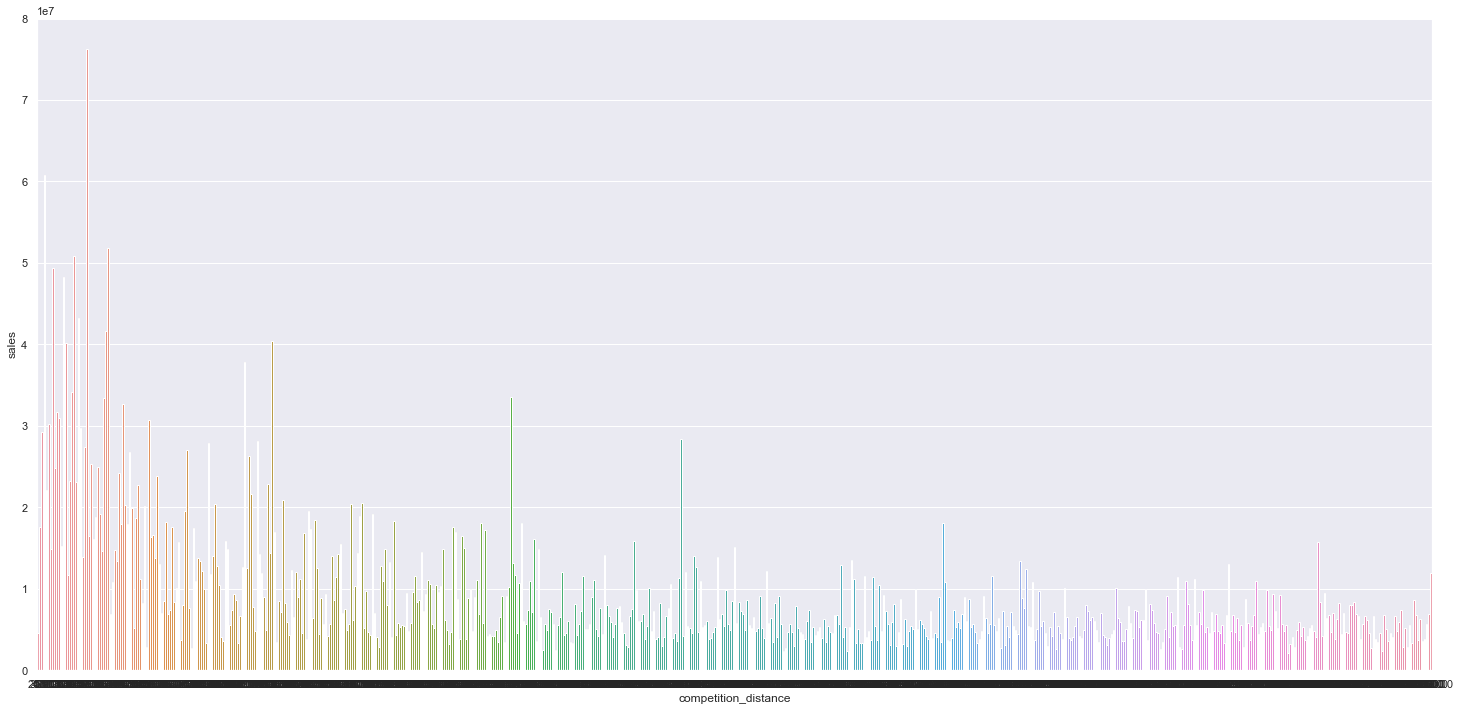

In [50]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

sns.barplot(x='competition_distance', y='sales', data=aux1)

In [51]:
#ve como o grafico acima fica extremamente granularizado?
bins = list(np.arange(0, 20000, 1000))

aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)



In [52]:
#pegando uma amostra
aux1.sample()

,competition_distance,sales,competition_distance_binned
433,7930.0,5151315,"(7000, 8000]"


<AxesSubplot:xlabel='competition_distance_binned', ylabel='sales'>

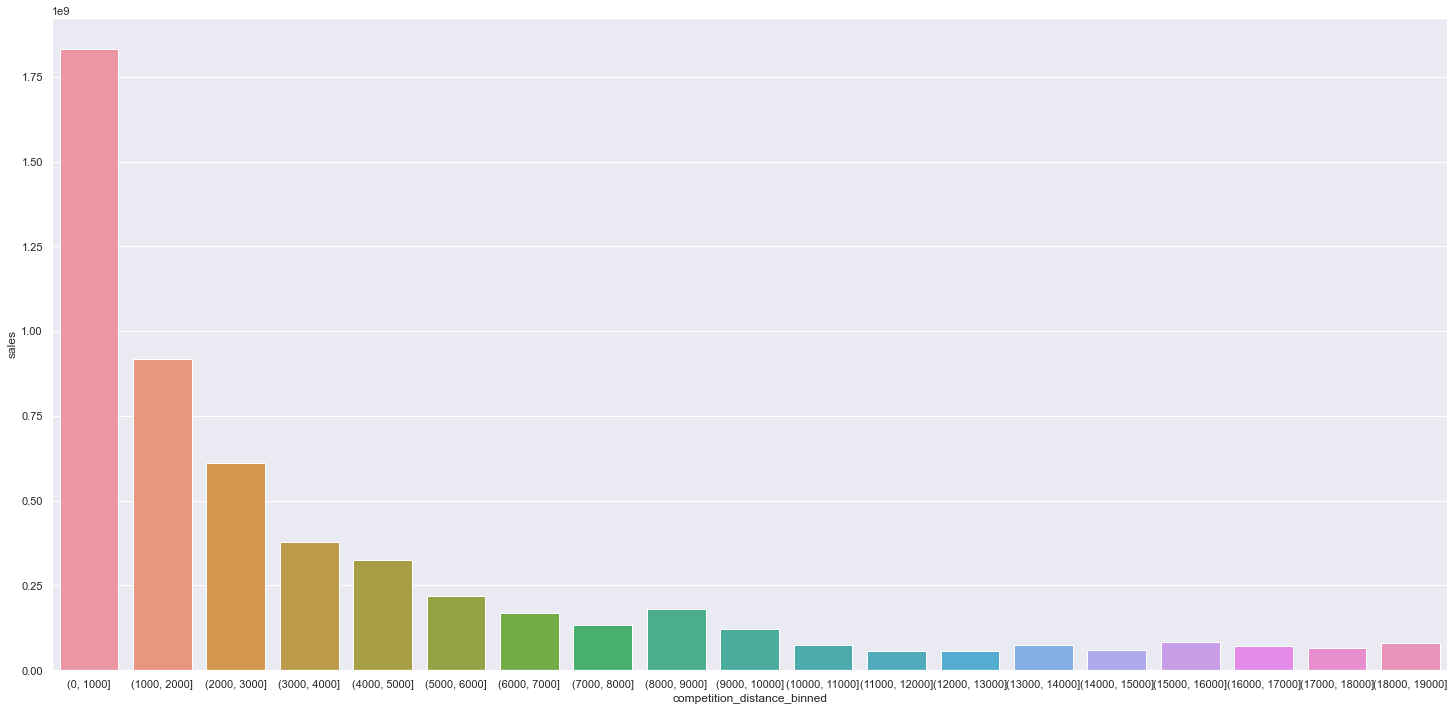

In [53]:
#plotando os valores binned
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned',y='sales',data=aux2)

<AxesSubplot:xlabel='competition_distance', ylabel='sales'>

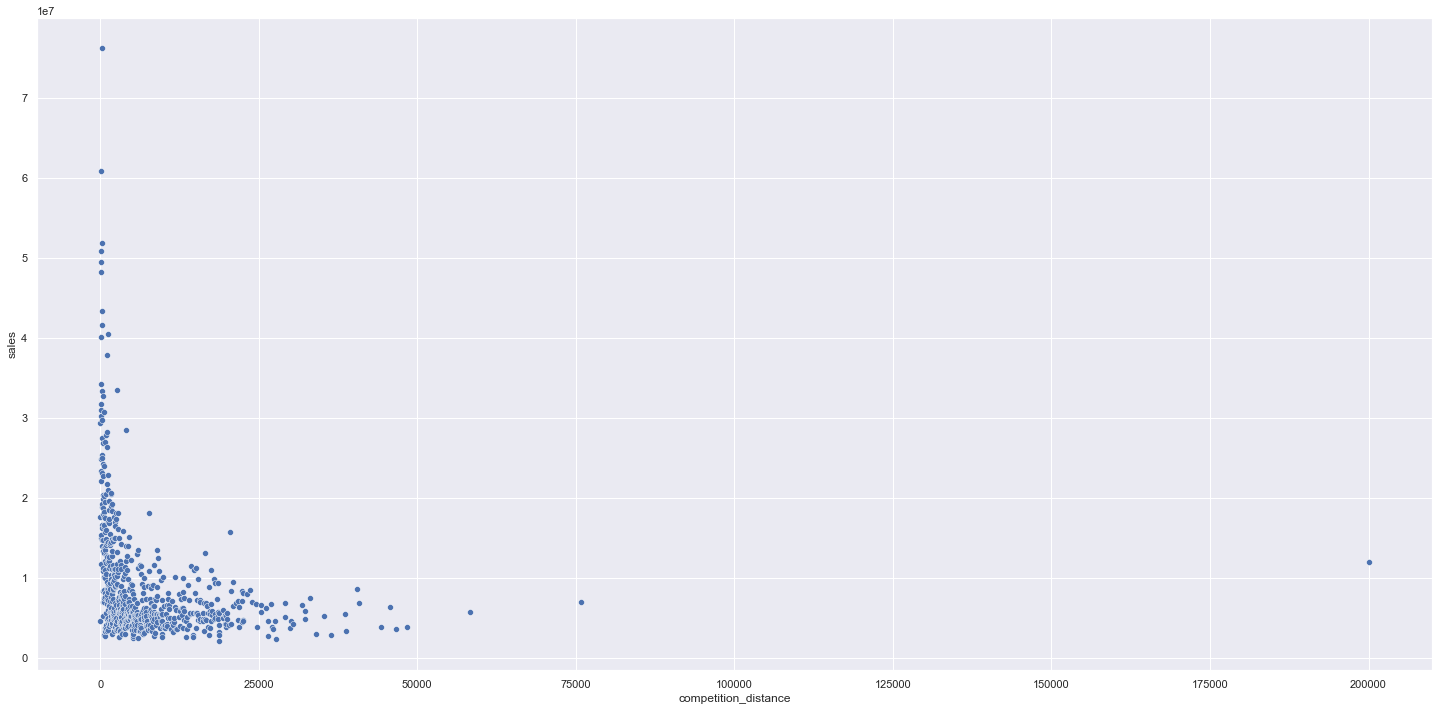

In [54]:
#usando o scatterplot para investigar a hipotese
aux_scatter = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
sns.scatterplot(x='competition_distance',y='sales', data=aux_scatter)

<AxesSubplot:>

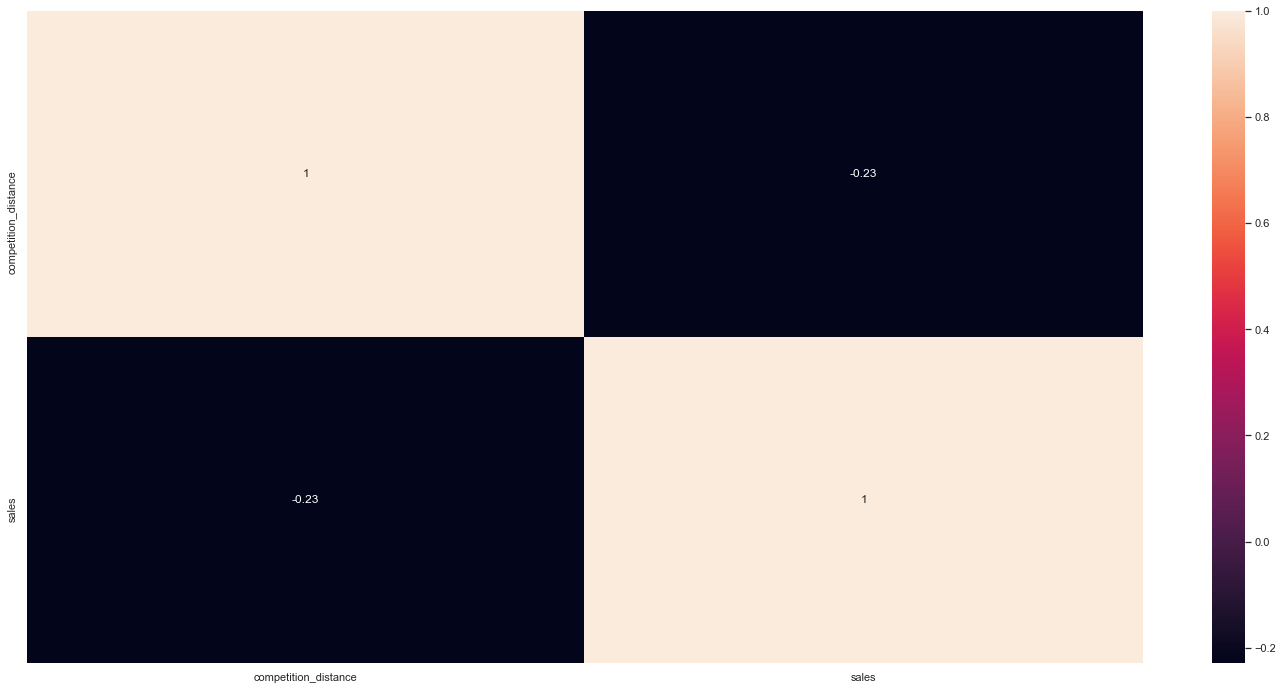

In [55]:
#verificando a correlacao entre distancia e vendas
sns.heatmap(aux_scatter.corr(method='pearson'), annot=True,)

#### Conclusão: Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS - FALSA

### H3. Lojas com competidores a mais tempo deveriam vender menos.

In [56]:
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


In [57]:
#valor maximo da coluna
df4['competition_time_month'].max()

1407

<AxesSubplot:>

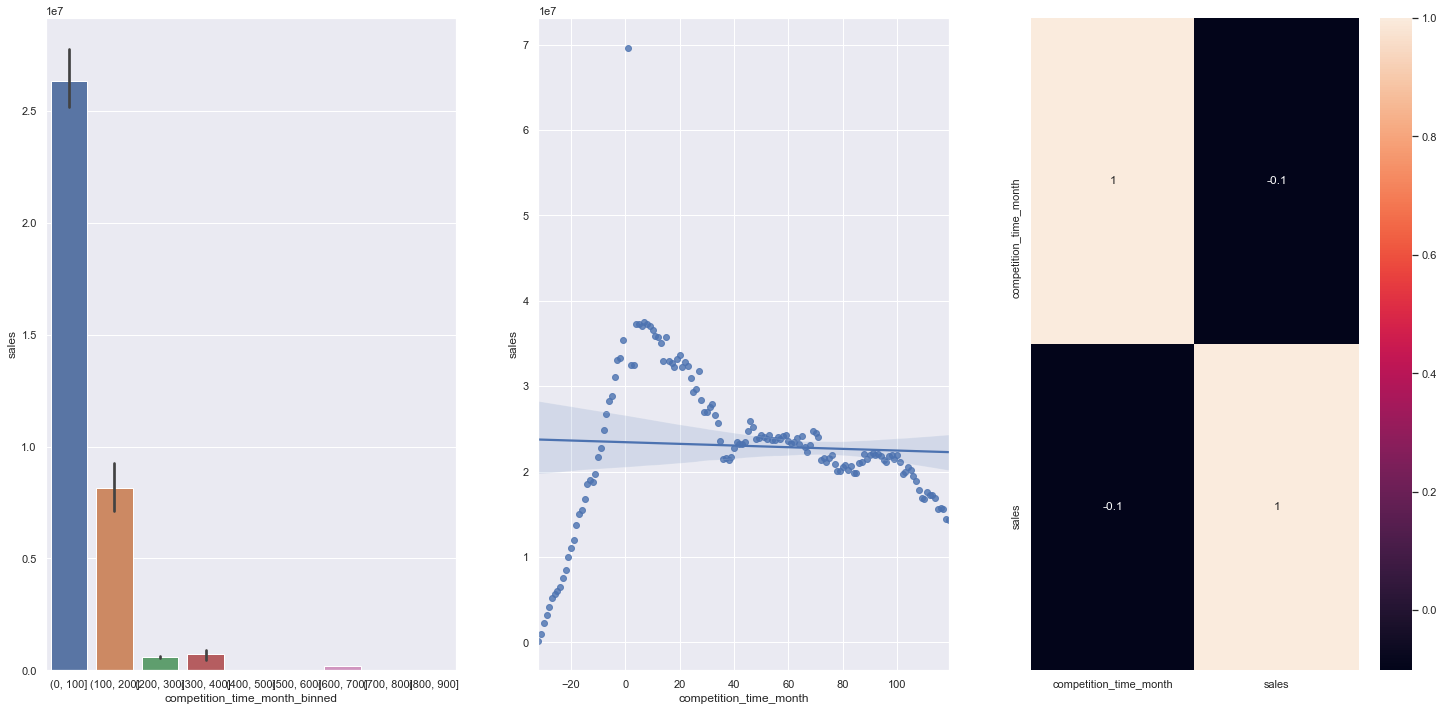

In [58]:
aux_competition_time = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
bins = list(np.arange(0,1000,100))
#plt.subplot(1,2,1)
#sns.barplot(x='competition_time_month',y='sales', data=aux_competition_time)

aux_competition_time['competition_time_month_binned'] = pd.cut(aux_competition_time['competition_time_month'], bins=bins)
plt.subplot(1,3,1)
sns.barplot(x='competition_time_month_binned',y='sales', data=aux_competition_time)

plt.subplot(1,3,2)
#grafico de tendencia
first_120_months = aux_competition_time[(aux_competition_time['competition_time_month'] < 120) & (aux_competition_time['competition_time_month'] !=0)]
sns.regplot(x='competition_time_month', y='sales', data=first_120_months)

plt.subplot(1,3,3)
sns.heatmap(aux_competition_time.corr(method='pearson'),annot=True)

#### Conclusão: Lojas com COMPETIDORES HÁ MAIS TEMPO vendem MENOS - FALSA

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.

In [59]:
df4['promo_time_week'].max()

313

<AxesSubplot:xlabel='promo_time_week', ylabel='sales'>

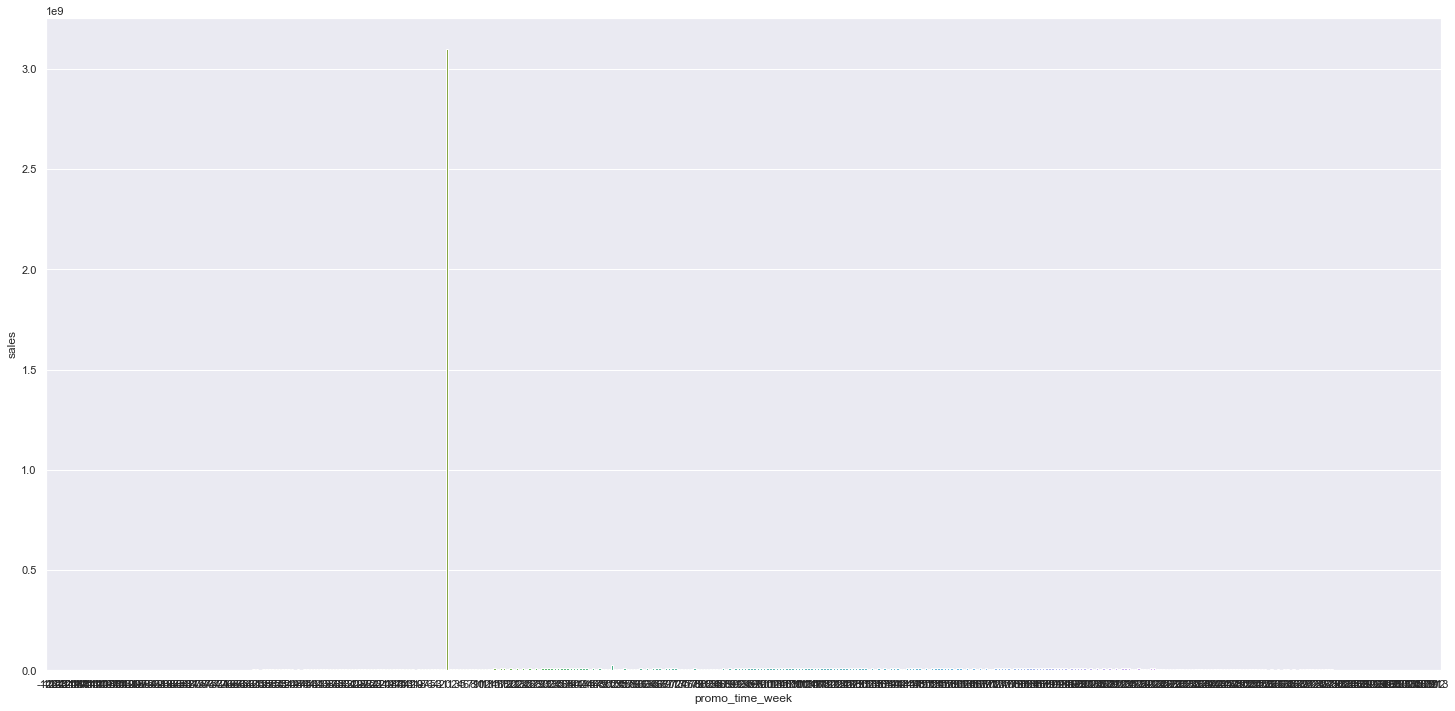

In [60]:
aux_promo_time = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
sns.barplot(x='promo_time_week',y='sales', data=aux_promo_time)

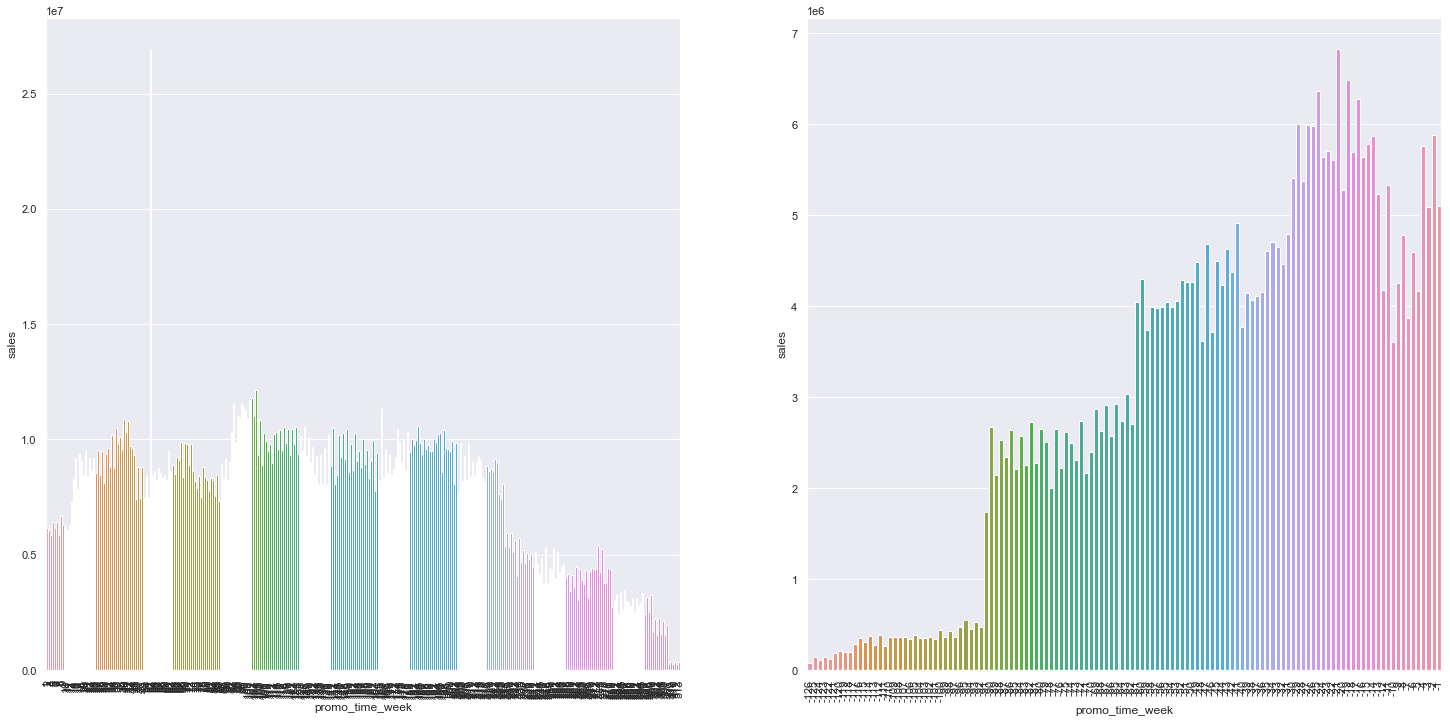

In [61]:
#fazendo cortes na base de dados
aux_extended_promo = aux_promo_time[aux_promo_time['promo_time_week'] > 0]
aux_regular_promo = aux_promo_time[aux_promo_time['promo_time_week'] < 0]
plt.subplot(1,2,1)
sns.barplot(x='promo_time_week', y='sales', data=aux_extended_promo)
plt.xticks(rotation=90)
plt.subplot(1,2,2)
sns.barplot(x='promo_time_week', y='sales', data=aux_regular_promo)
plt.xticks(rotation=90);


<AxesSubplot:xlabel='promo_time_week_binned', ylabel='sales'>

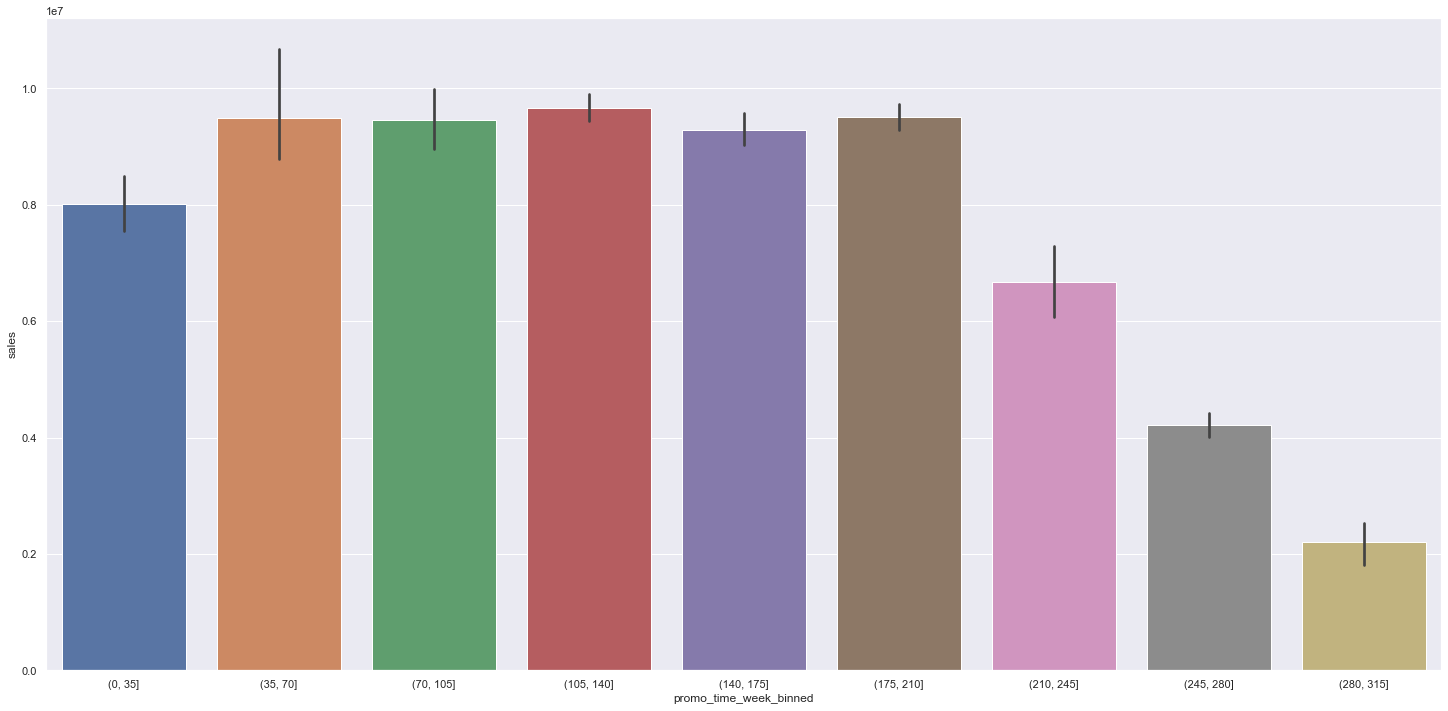

In [62]:
bins = list(np.arange(0,350,35))
aux_promo_time['promo_time_week_binned'] = pd.cut(aux_promo_time['promo_time_week'], bins=bins)
sns.barplot(x='promo_time_week_binned', y='sales', data=aux_promo_time)


<AxesSubplot:xlabel='promo_time_week', ylabel='sales'>

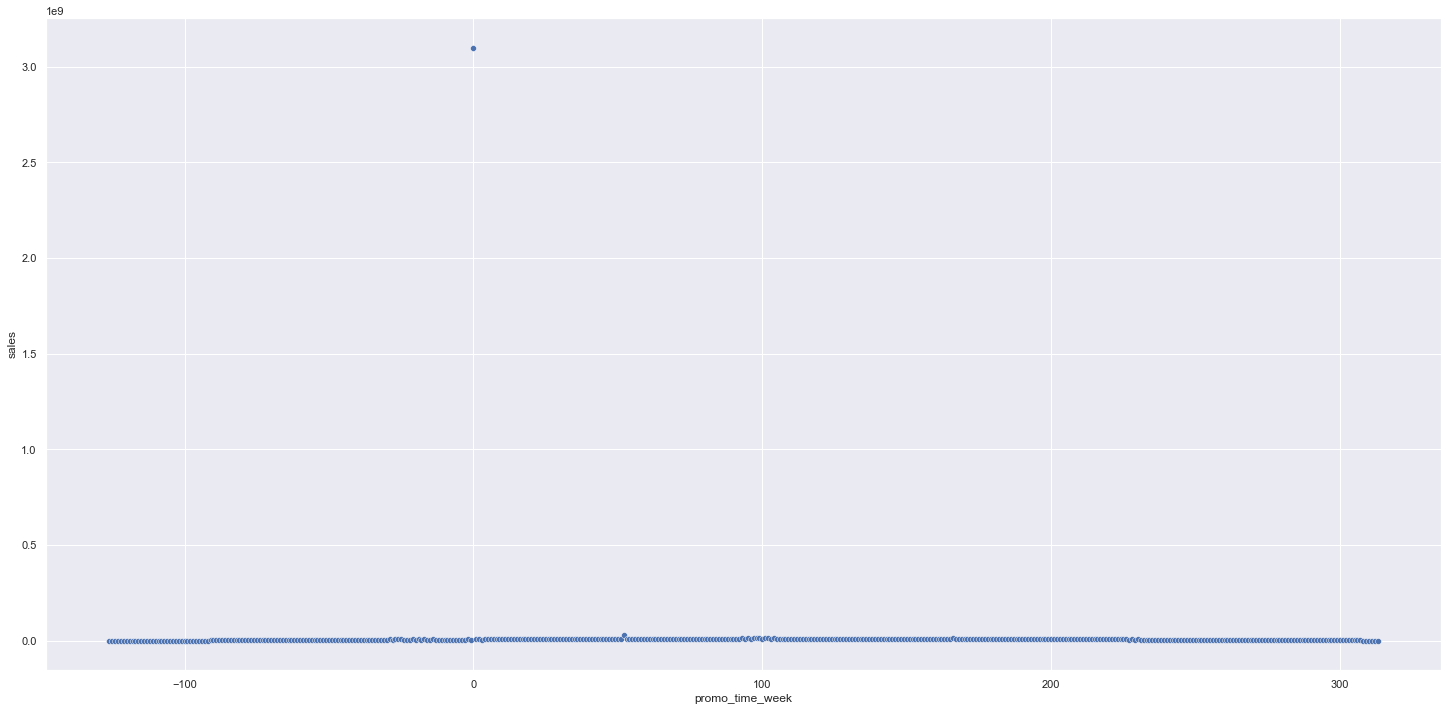

In [63]:
sns.scatterplot(x='promo_time_week', y='sales', data=aux_promo_time)

<AxesSubplot:>

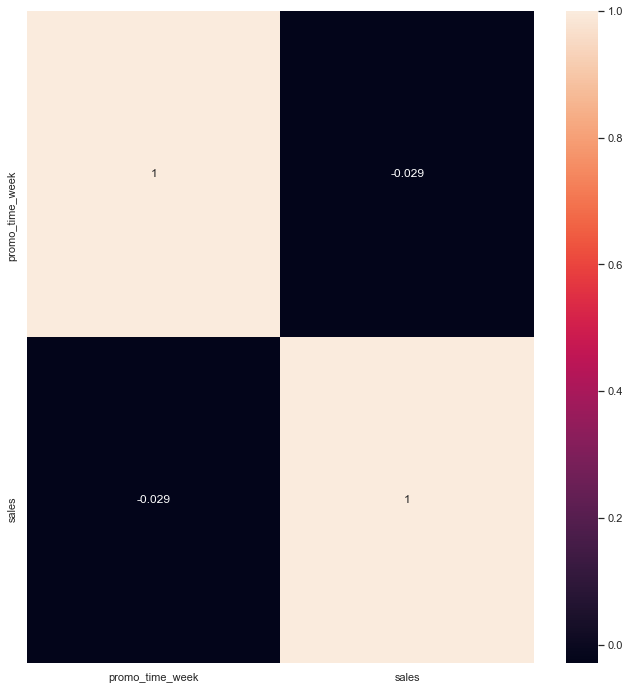

In [64]:
plt.subplot(1,2,1)
sns.heatmap(aux_promo_time.corr(method='pearson'), annot=True)


<AxesSubplot:xlabel='promo_time_week', ylabel='sales'>

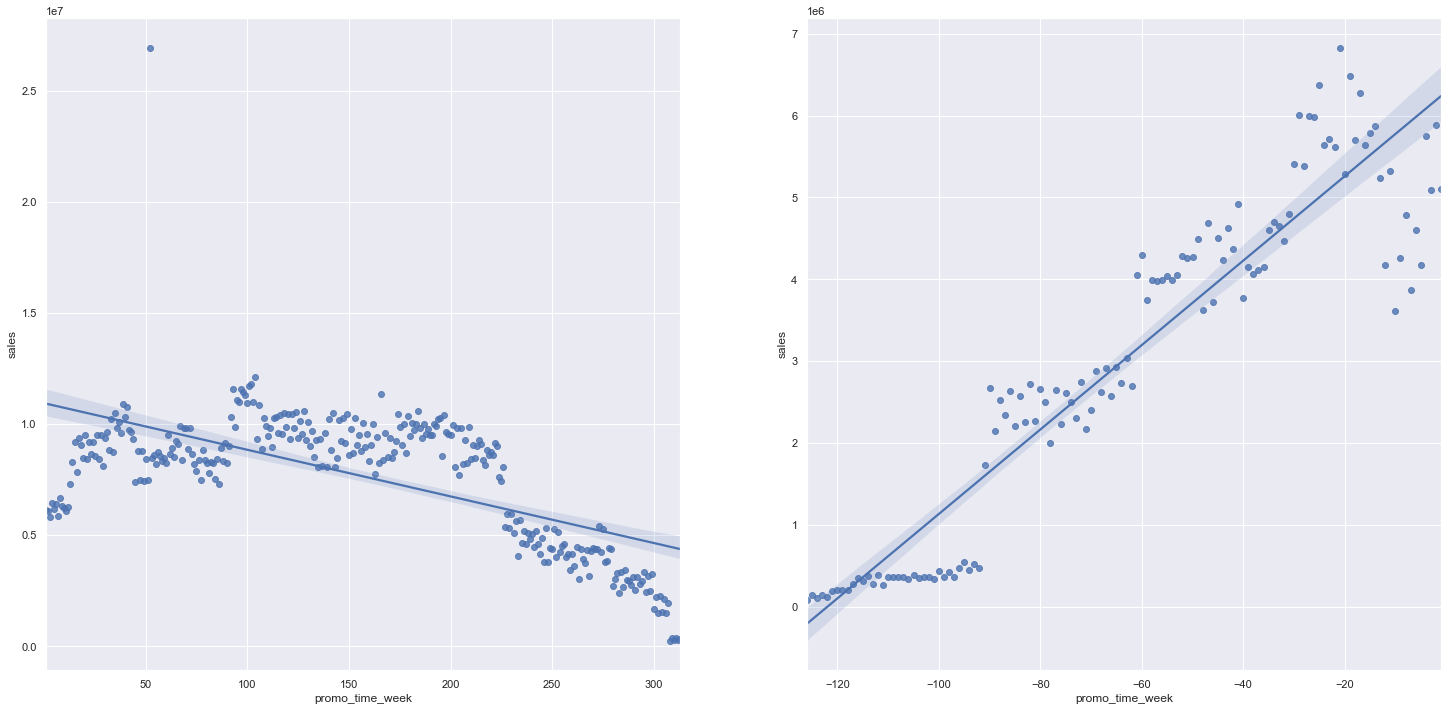

In [65]:
plt.subplot(1,2,1)
sns.regplot(x='promo_time_week', y='sales',data=aux_extended_promo)
plt.subplot(1,2,2)
sns.regplot(x='promo_time_week', y='sales', data=aux_regular_promo)

#### Conclusão: Lojas com PROMOÇÕES A MAIS TEMPO vendem MENOS - FALSA

### <s> H5. Lojas com mais dias de promoção deveriam vender mais.</s>


In [66]:
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


### H6. Lojas com mais promoções consecutivas deveriam vender mais.

In [67]:
df4[['promo','promo2','sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


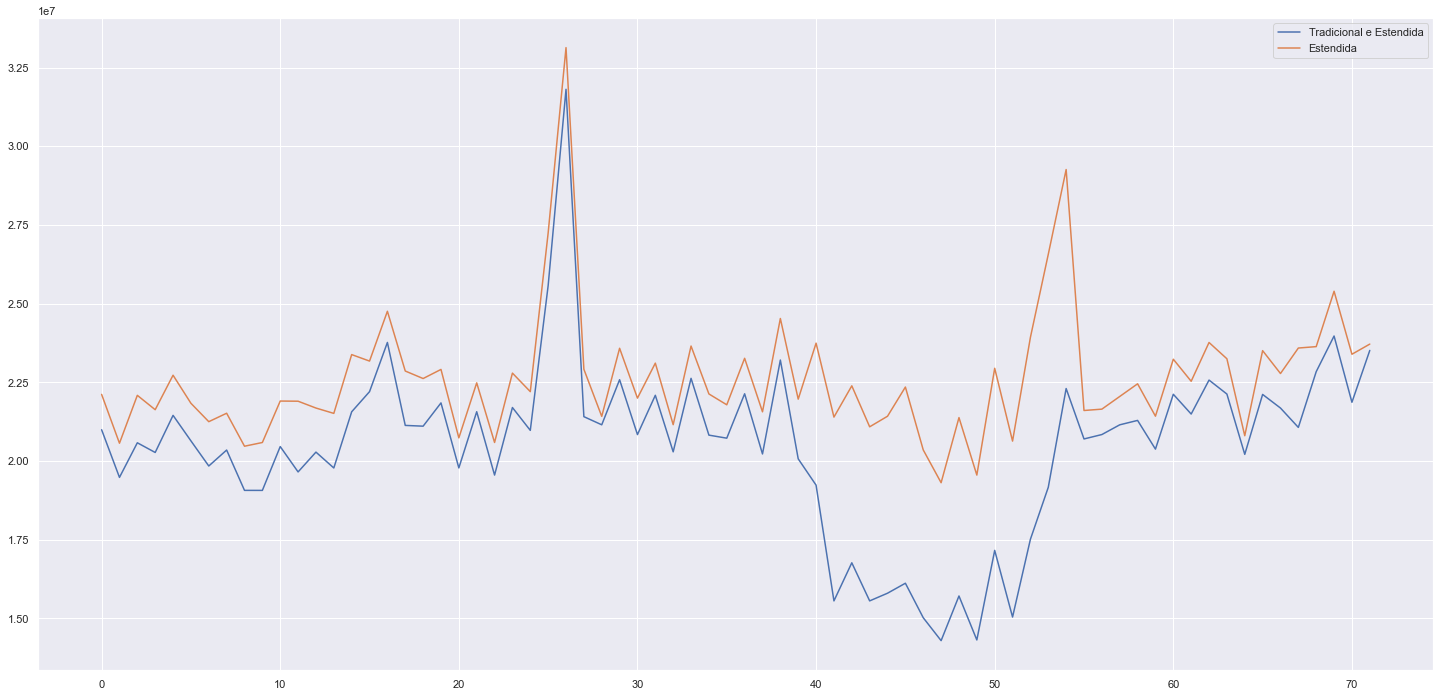

In [68]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()
aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)
ax.legend(labels=['Tradicional e Estendida', 'Estendida'])

#### Conclusão: Lojas com PROMOÇÕES CONSECUTIVAS vendem MENOS - FALSA

### H7. Lojas abertas durante o feriado de Natal deveriam vender mais.


<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

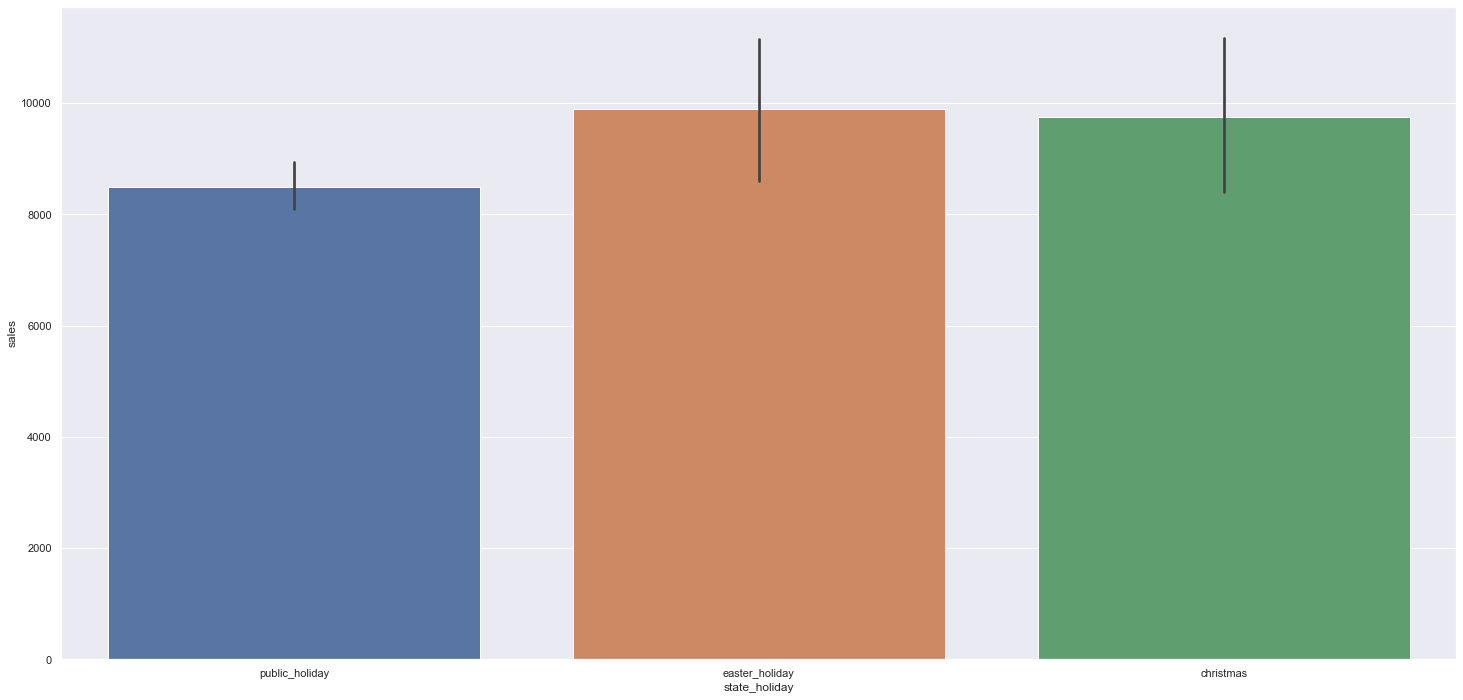

In [84]:
aux_holidays_without_regular = df4[df4['state_holiday'] != 'regular_day']
sns.barplot(x='state_holiday', y='sales', data=aux_holidays_without_regular)

In [85]:
aux_holidays_without_regular.sample()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
709554,85,4,2013-10-03,13297,0,public_holiday,1,b,basic,1870.0,10,2011,0,40,2013,0,2013,10,3,40,2013-39,2011-10-01,24,2013-09-30,0


<AxesSubplot:xlabel='year', ylabel='sales'>

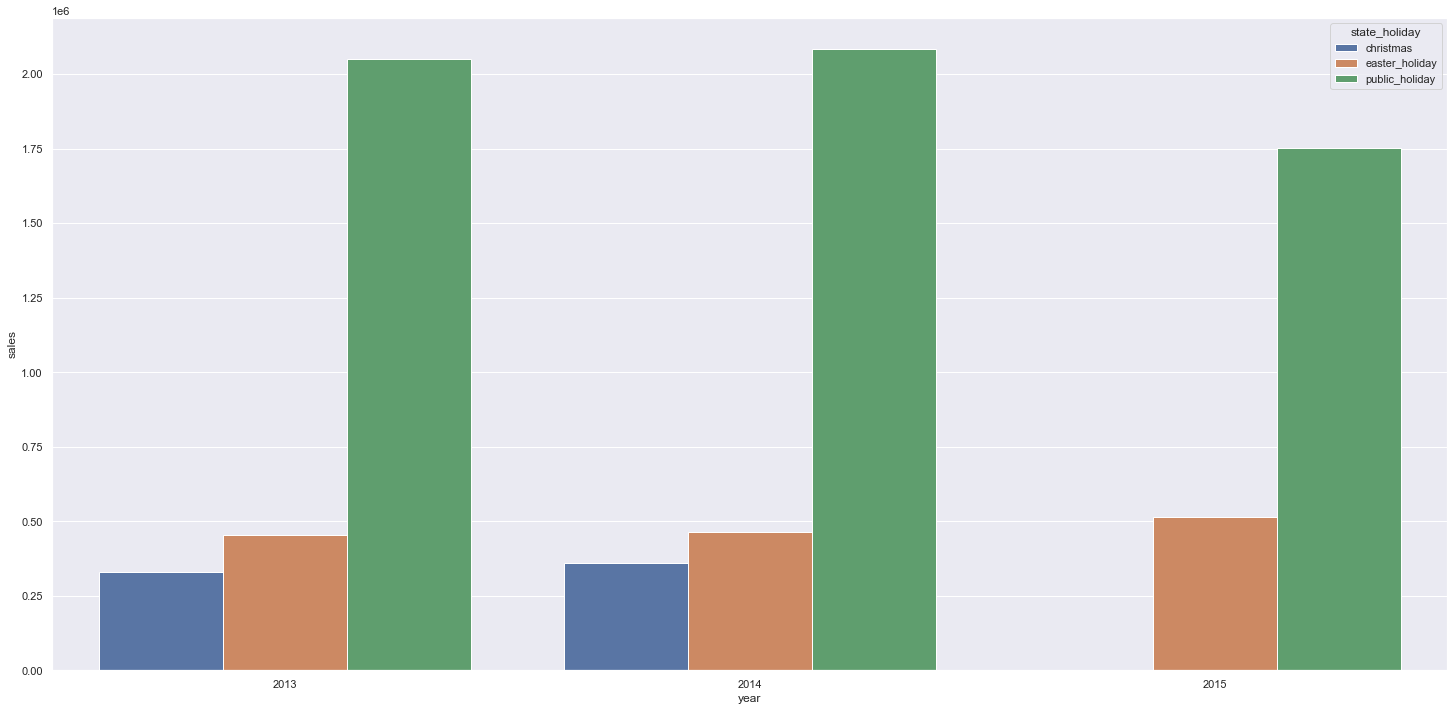

In [87]:
#fazendo o corte por ano
aux_year = aux_holidays_without_regular[['year', 'state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux_year)

#### Conclusão: Lojas ABERTAS DURANTE O NATAL vendem MENOS - FALSA

### H8. Lojas deveriam vender mais ao longo dos anos.



<AxesSubplot:xlabel='year', ylabel='sales'>

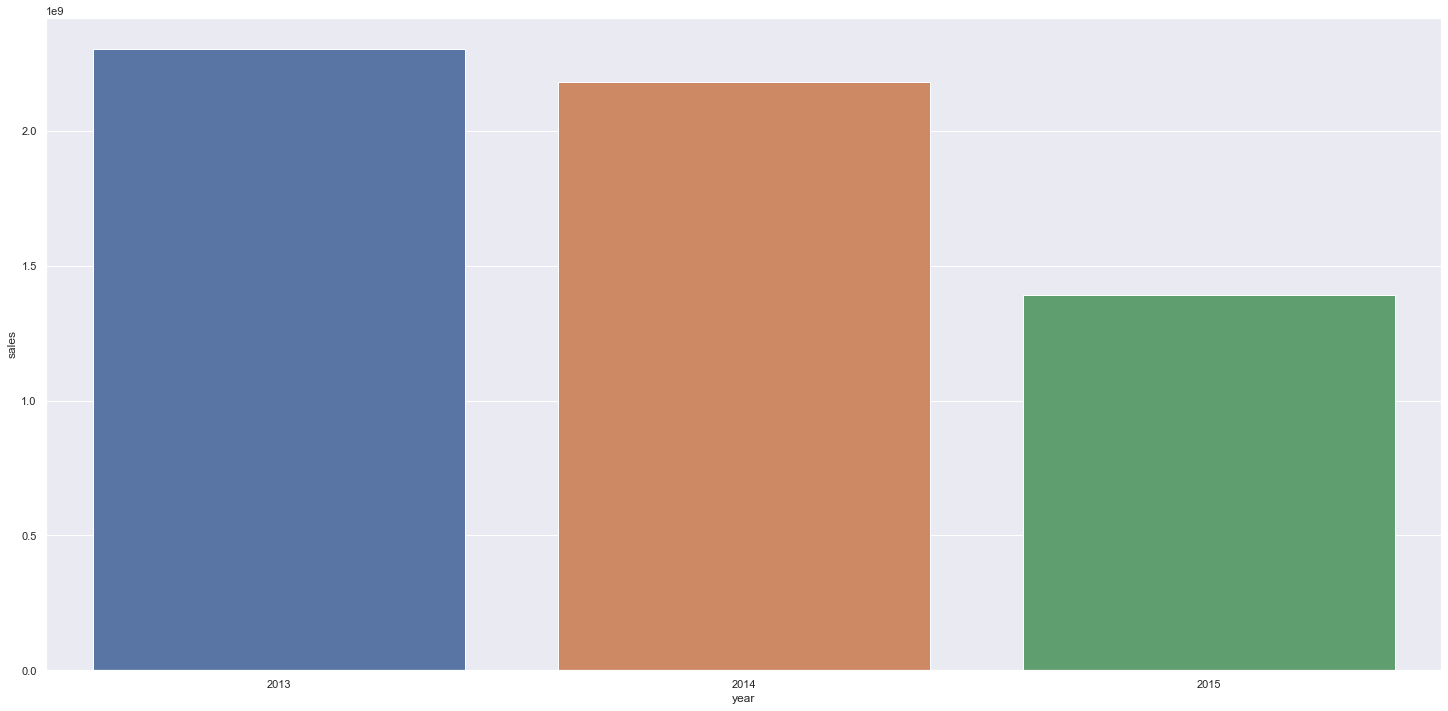

In [88]:
aux_yearly_sales = df4[['year','sales']].groupby('year').sum().reset_index()
sns.barplot(x='year',y='sales', data=aux_yearly_sales)

<AxesSubplot:xlabel='year', ylabel='sales'>

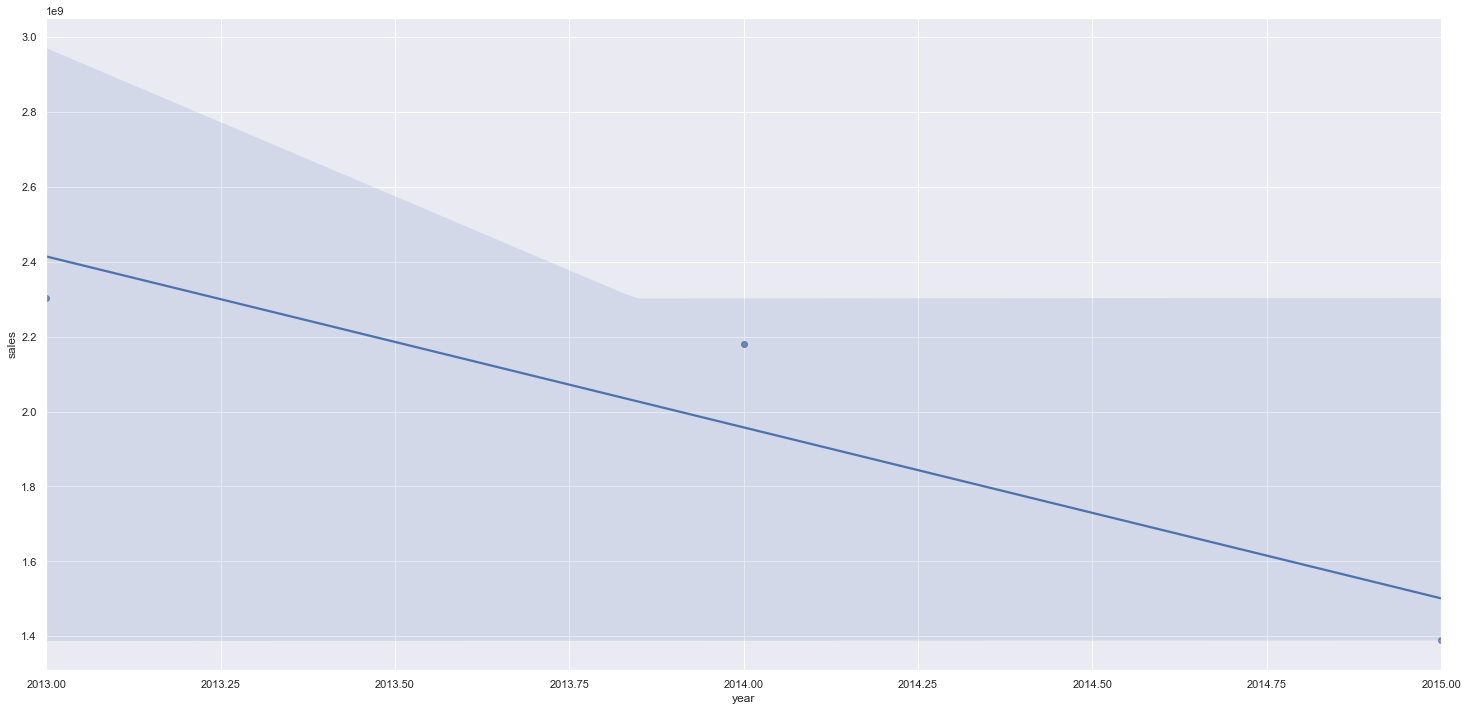

In [89]:
sns.regplot(x='year',y='sales', data=aux_yearly_sales)

<AxesSubplot:>

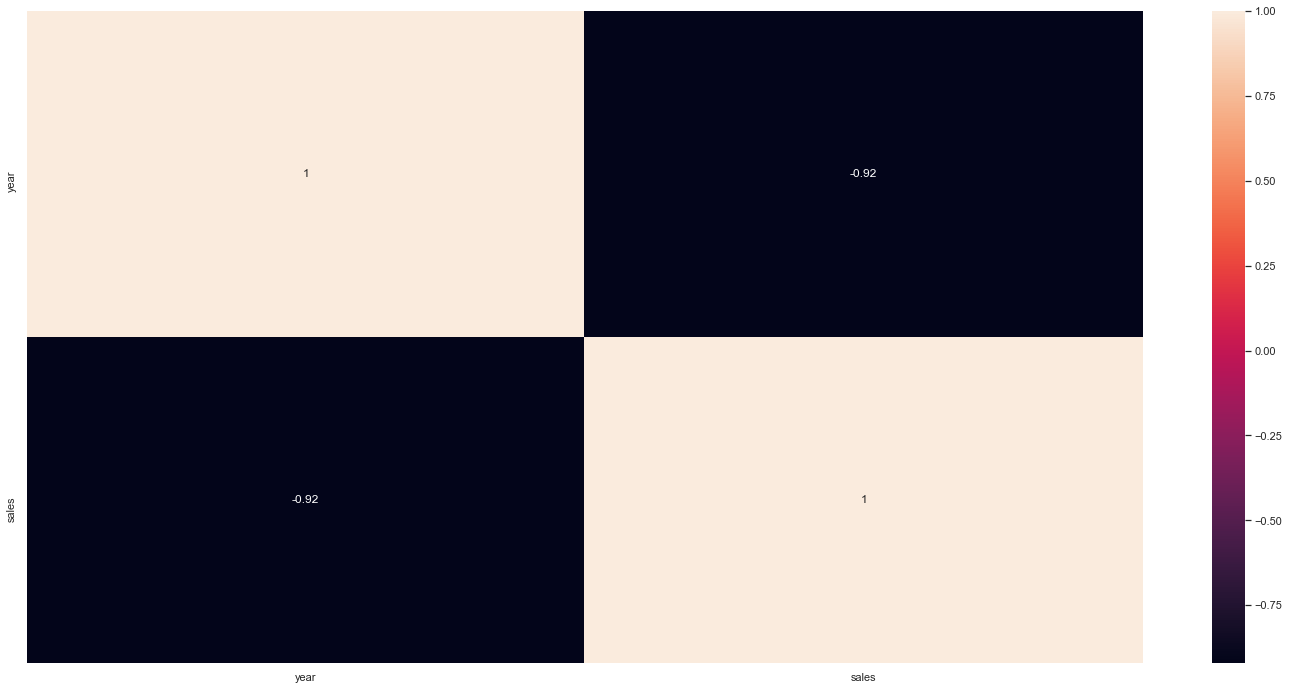

In [91]:
#forca da correlacao
sns.heatmap(aux_yearly_sales.corr(method='pearson'), annot=True)

#### Conclusão: Lojas VENDEM MENOS ao decorrer dos ANOS - FALSA



### H9. Lojas deveriam vender mais no segundo semestre do ano.


<AxesSubplot:xlabel='month', ylabel='sales'>

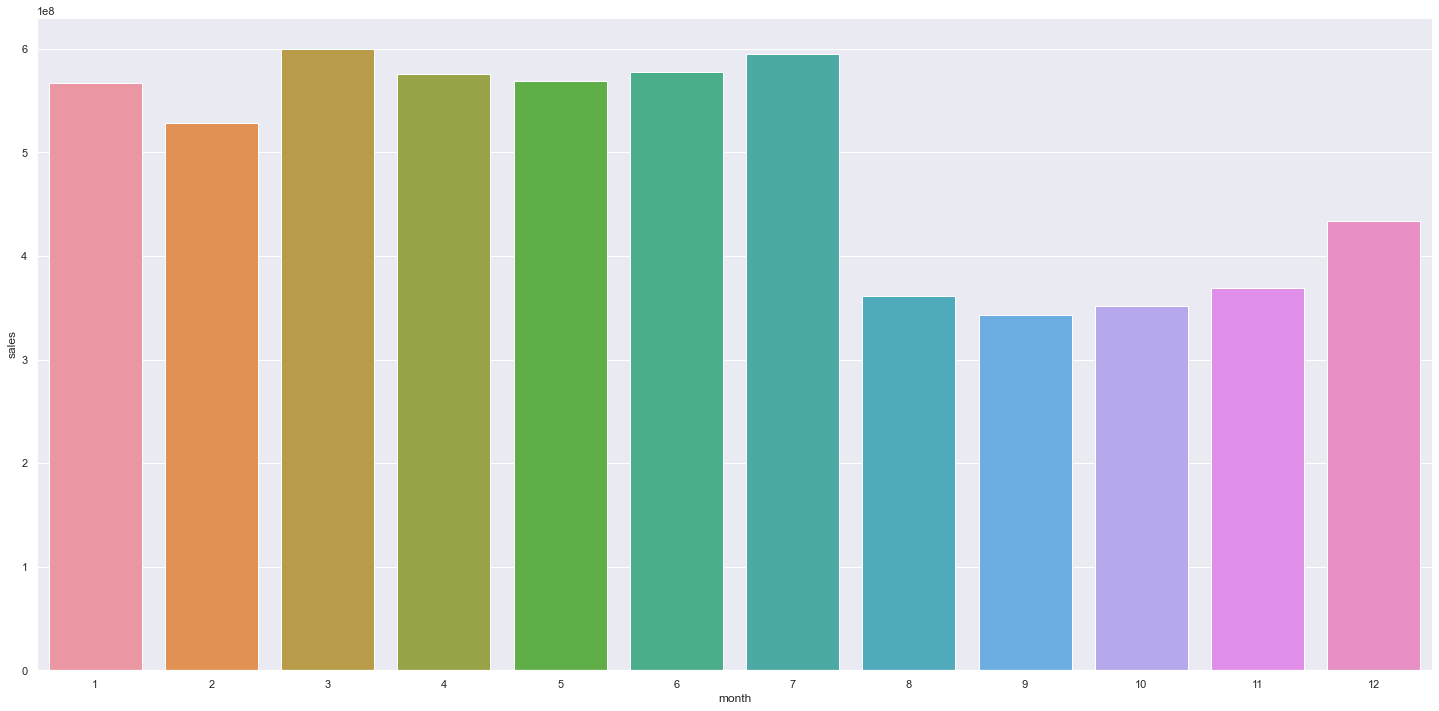

In [94]:
monthly_sales = df4[['month','sales']].groupby('month').sum().reset_index()
sns.barplot(x='month',y='sales',data=monthly_sales)

<AxesSubplot:xlabel='month', ylabel='sales'>

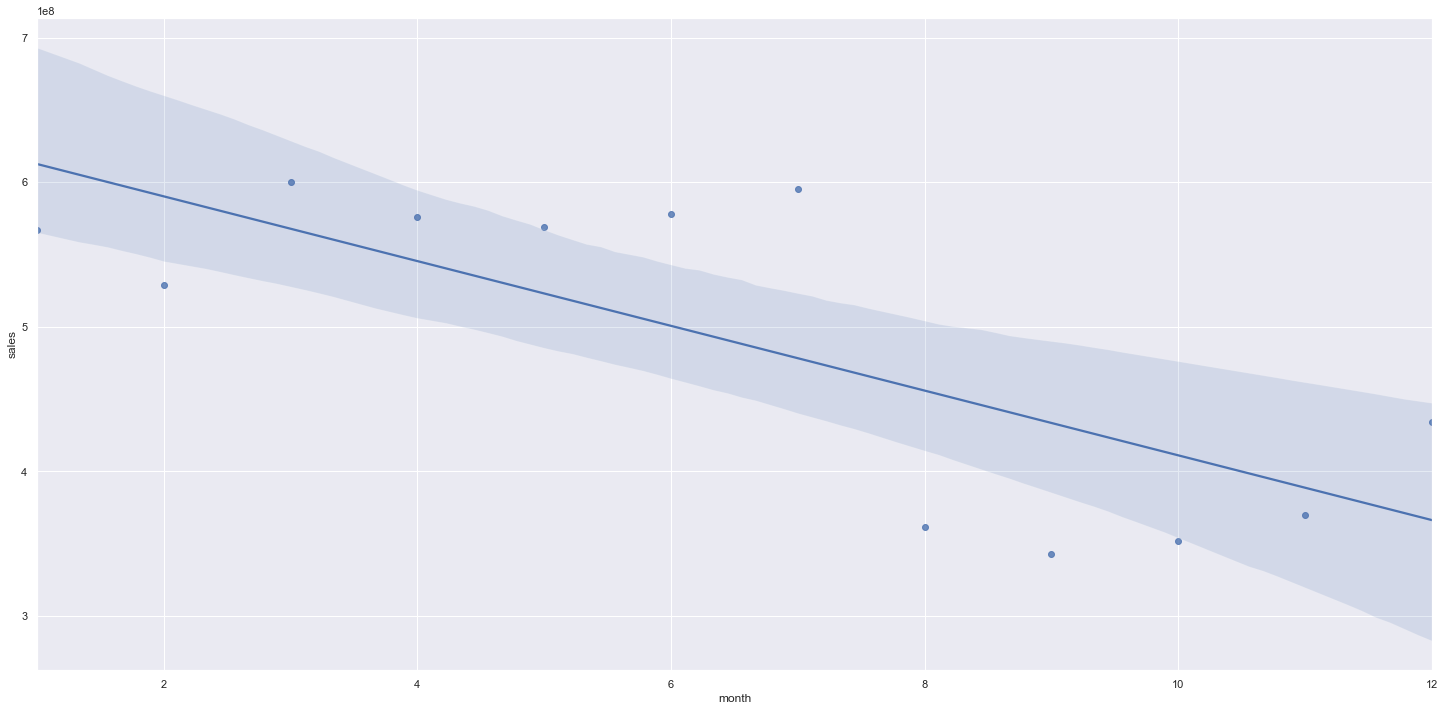

In [95]:
#tendencia
sns.regplot(x='month', y='sales', data=monthly_sales)

<AxesSubplot:>

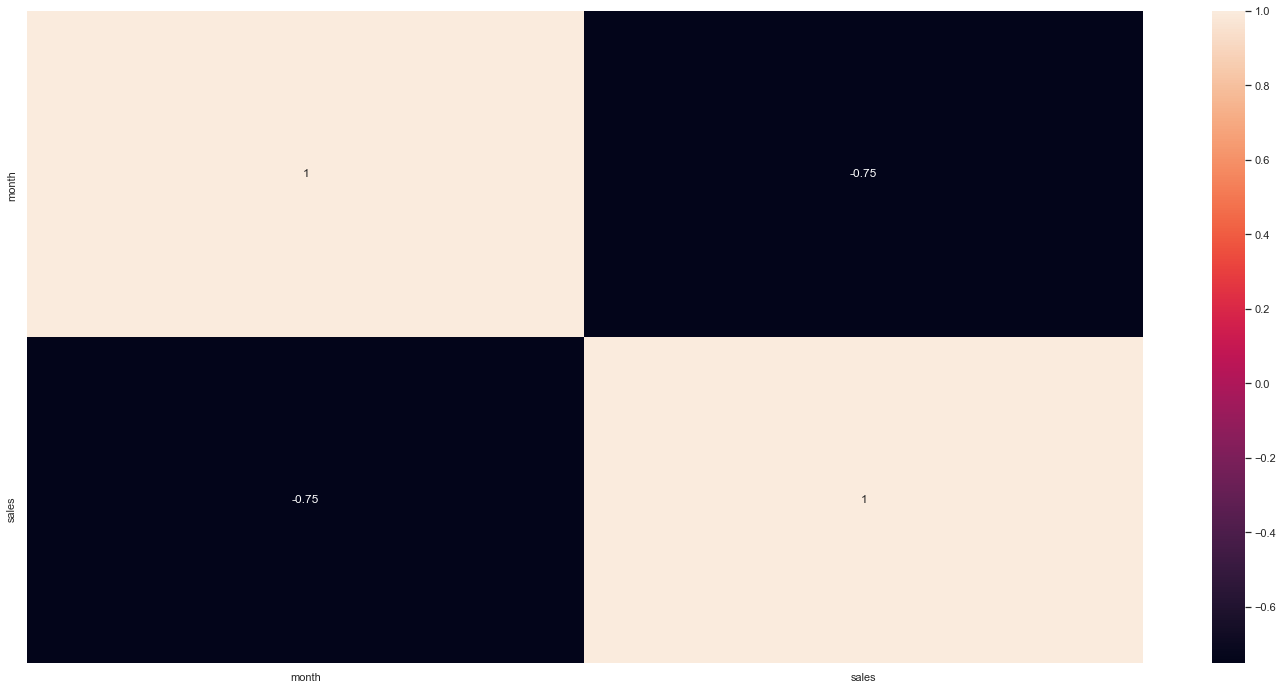

In [96]:
#forca da corr
sns.heatmap(monthly_sales.corr(method='pearson'), annot=True)

#### Conclusão: Lojas VENDEM MENOS a partir do SEGUNDO SEMESTRE - FALSA



### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.


<AxesSubplot:>

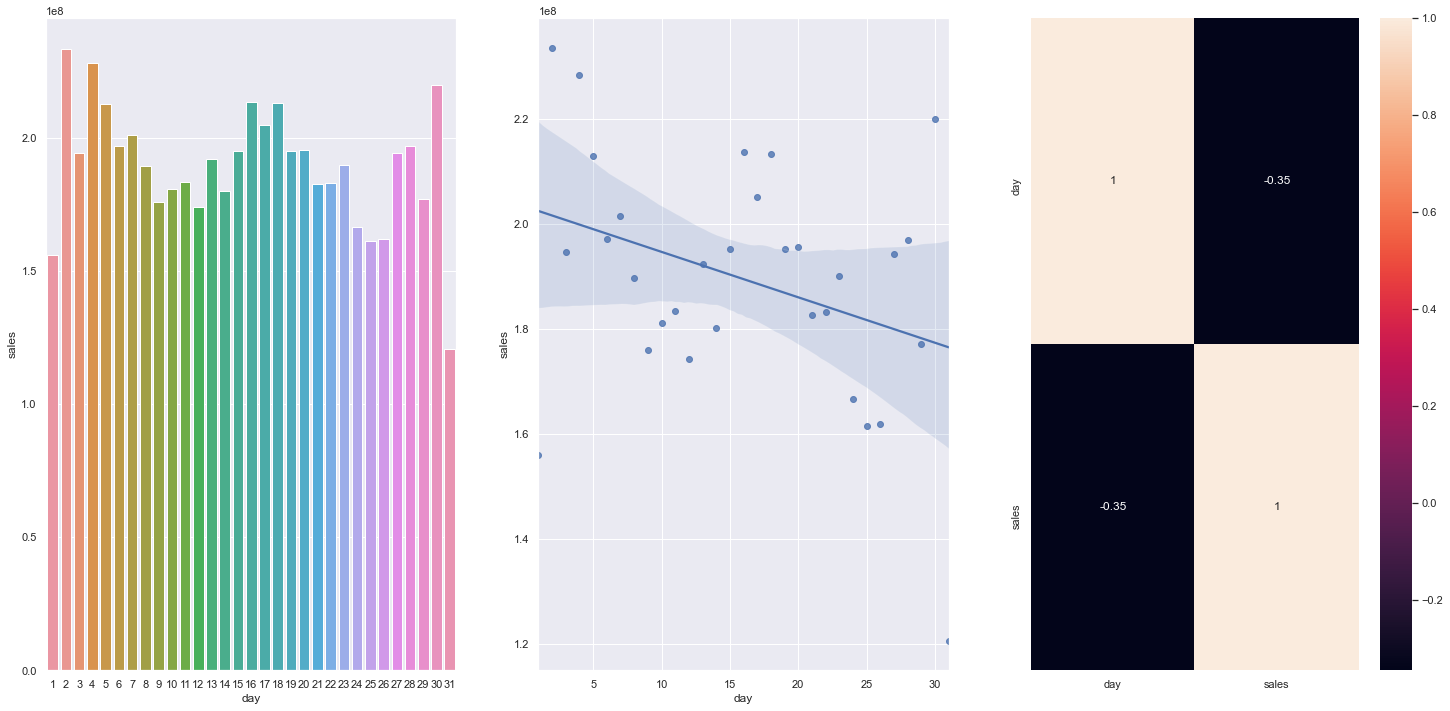

In [97]:
daily_sales = df4[['day', 'sales']].groupby('day').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(x='day', y='sales',data=daily_sales)
plt.subplot(1,3,2)
sns.regplot(x='day', y='sales', data=daily_sales)
plt.subplot(1,3,3)
sns.heatmap(daily_sales.corr(method='pearson'), annot=True)

In [105]:
#avaliando os dois periodos < 10 e > 10
#criando nova coluna para classificar os dias

daily_sales['before_after'] = daily_sales['day'].apply(lambda x: 'before_10_day' if x <=10 else 'after_10_day')


<AxesSubplot:xlabel='before_after', ylabel='sales'>

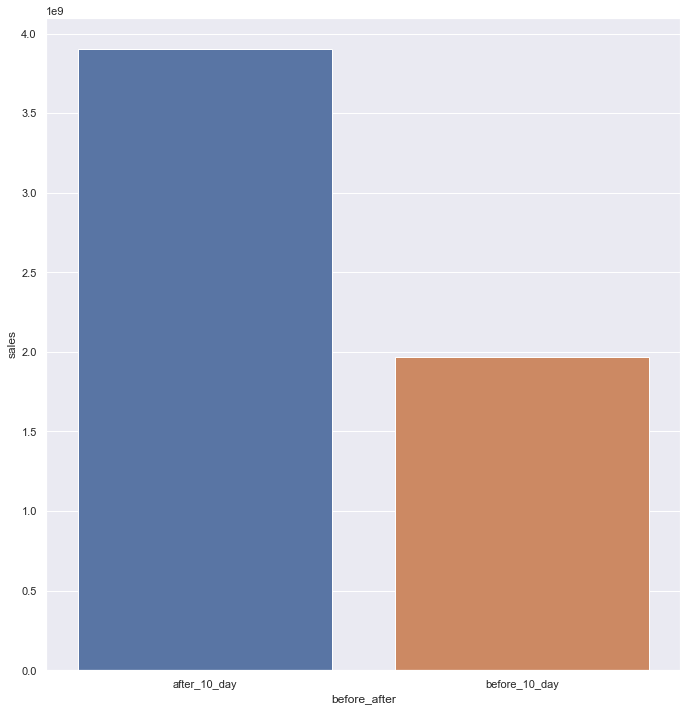

In [115]:
sales_result = daily_sales[['before_after','sales']].groupby('before_after').sum().reset_index()
plt.subplot(1,2,1)
sns.barplot(x='before_after', y='sales',data=sales_result)


#### Conclusão: Lojas VENDEM MAIS a partir do DIA 10 - VERDADEIRA



### H11. Lojas deveriam vender menos aos finais de semana.



In [124]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

In [129]:
#criando coluna para identificar fins de semana
weekly_sales = df4
weekly_sales['week_weekend'] = df4['day_of_week'].apply(lambda x: 'weekend' if x > 5 else 'week')
weekly_sales.sample(20)


,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,week_weekend
405447,923,5,2014-07-04,5044,1,regular_day,0,a,basic,280.0,9,2008,0,27,2014,0,2014,7,4,27,2014-26,2008-09-01,71,2014-06-30,0,week
372626,808,5,2014-08-08,7610,1,regular_day,1,a,basic,18620.0,8,2014,1,31,2009,1,2014,8,8,32,2014-31,2014-08-01,0,2009-07-27,262,week
148281,1102,6,2015-03-21,6839,0,regular_day,0,a,basic,850.0,11,2012,1,40,2014,0,2015,3,21,12,2015-11,2012-11-01,29,2014-09-29,24,weekend
284693,757,1,2014-11-10,7958,1,regular_day,0,a,extended,3450.0,11,2014,0,46,2014,0,2014,11,10,46,2014-45,2014-11-01,0,2014-11-10,0,week
510365,481,1,2014-03-31,7553,1,regular_day,0,c,extended,7470.0,3,2014,1,44,2012,0,2014,3,31,14,2014-13,2014-03-01,1,2012-10-22,75,week
629303,114,6,2013-12-14,7053,0,regular_day,0,c,basic,4510.0,12,2013,1,48,2011,1,2013,12,14,50,2013-49,2013-12-01,0,2011-11-21,107,weekend
918415,441,6,2013-03-30,9225,0,regular_day,0,d,basic,2530.0,3,2013,0,13,2013,0,2013,3,30,13,2013-12,2013-03-01,0,2013-03-25,0,weekend
756333,34,4,2013-08-22,5881,0,regular_day,0,c,basic,2240.0,9,2009,0,34,2013,0,2013,8,22,34,2013-33,2009-09-01,48,2013-08-19,0,week
240918,957,6,2014-12-27,6091,0,regular_day,0,d,extended,1420.0,11,2012,0,52,2014,0,2014,12,27,52,2014-51,2012-11-01,26,2014-12-22,0,weekend
629998,809,6,2013-12-14,8536,0,regular_day,0,a,basic,12770.0,10,2000,0,50,2013,0,2013,12,14,50,2013-49,2000-10-01,160,2013-12-09,0,weekend


<AxesSubplot:xlabel='week_weekend', ylabel='sales'>

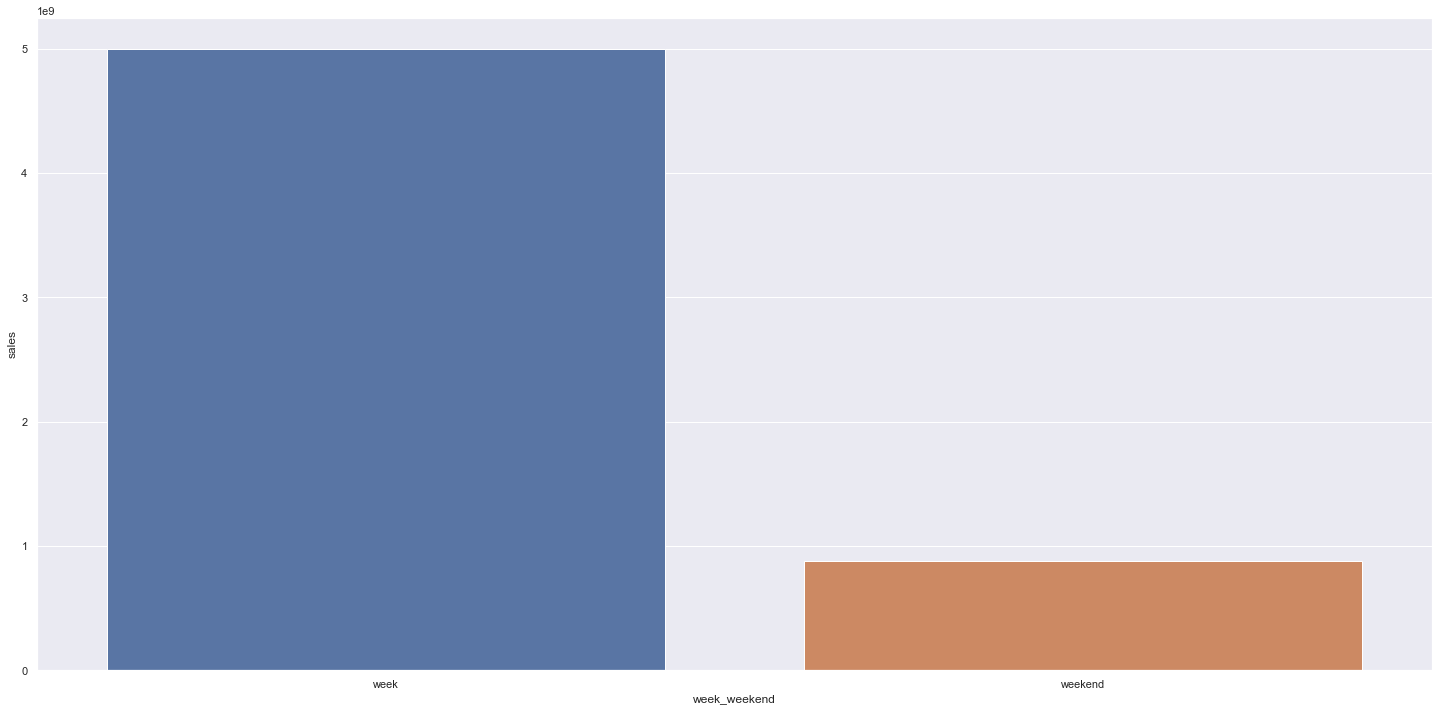

In [132]:
aux1 = weekly_sales[['week_weekend','sales']].groupby('week_weekend').sum().reset_index()
sns.barplot(x='week_weekend', y='sales', data=aux1)

#### Conclusão: Lojas VENDEM MENOS nos finais de SEMANA - VERDADEIRA


### H12. Lojas deveriam vender menos durante os feriados escolares.

<AxesSubplot:>

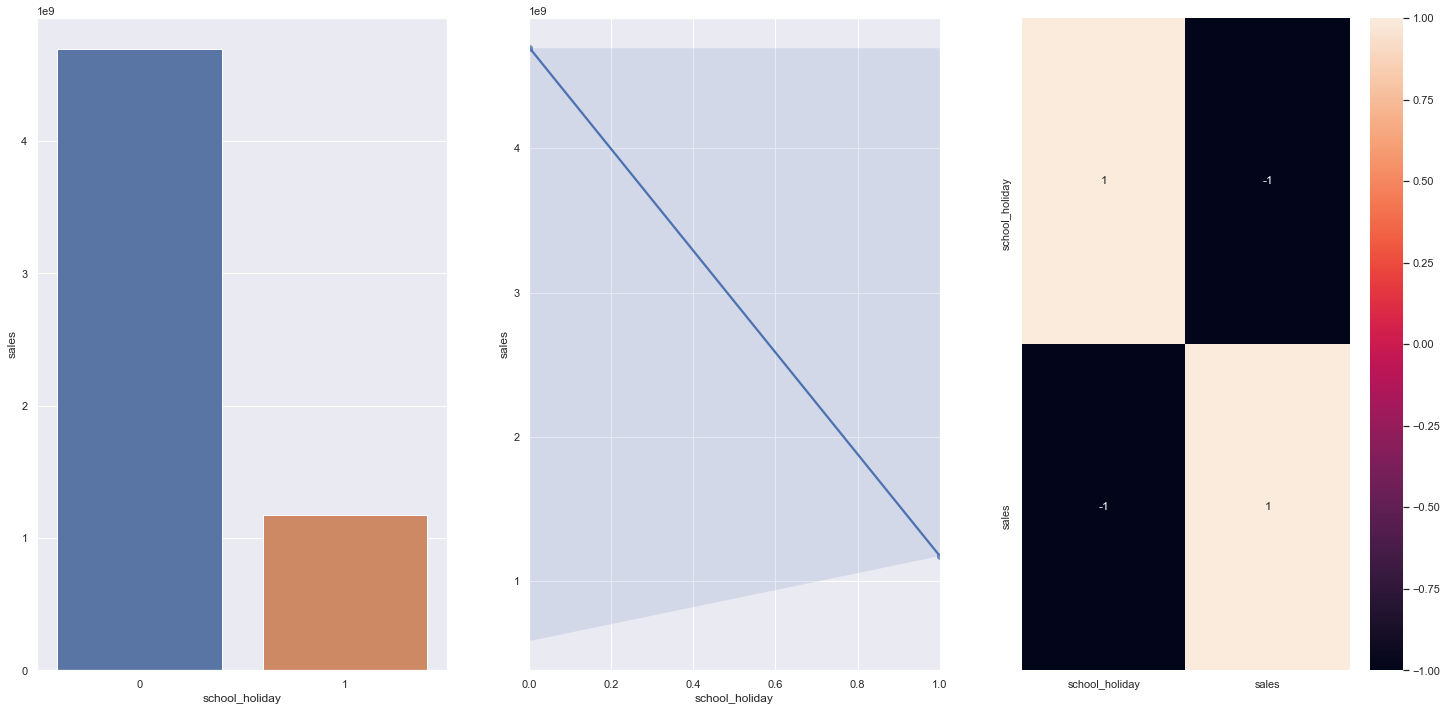

In [139]:
aux_school_holiday = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(x='school_holiday', y='sales', data=aux_school_holiday)
plt.subplot(1,3,2)
sns.regplot(x='school_holiday', y='sales', data=aux_school_holiday)
plt.subplot(1,3,3)
sns.heatmap(aux_school_holiday.corr(method='pearson'), annot=True)

<AxesSubplot:xlabel='month', ylabel='sales'>

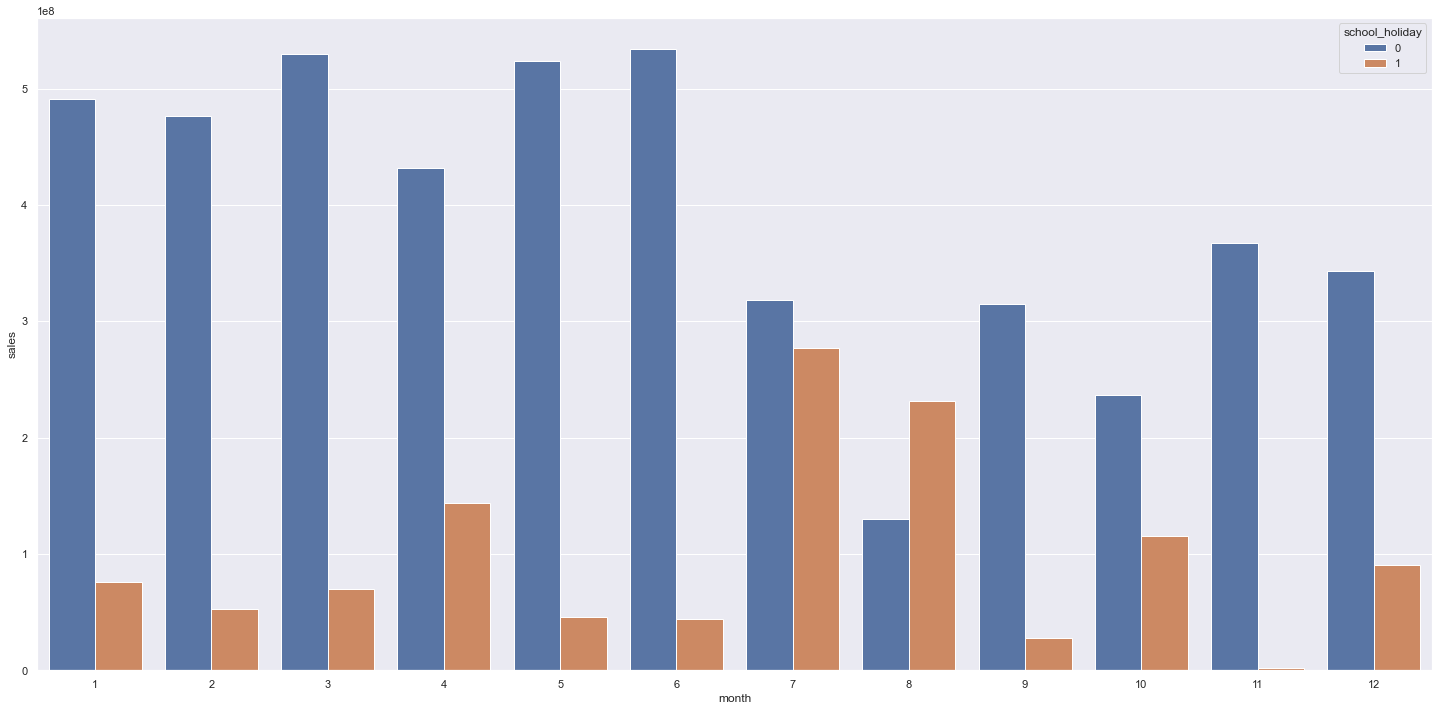

In [142]:
#fazendo o corte por mes
aux2 = df4[['school_holiday','month', 'sales']].groupby(['school_holiday', 'month']).sum().reset_index()
sns.barplot(x='month', hue='school_holiday', y='sales', data=aux2)

#### Conclusão: Lojas VENDEM MENOS nos FERIADOS ESCOLARES, EXCETO Julho e Agosto - VERDADEIRA


### 4.2.1. Resumo das Hipoteses

In [144]:
!pip install tabulate

You should consider upgrading via the 'pip install --upgrade pip' command.


In [145]:
from tabulate import tabulate

In [146]:
tab = [['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Falsa', 'Media'], 
       ['H3', 'Falsa', 'Media'], 
       ['H4', 'Falsa', 'Baixa'], 
       ['H5', '-', '-'],
        ['H6', 'Falsa', 'Baixa'],
        ['H7', 'Falsa', 'Media'],
        ['H8', 'Falsa', 'Alta'],
        ['H9', 'Falsa', 'Alta'],
        ['H10', 'Verdadeira', 'Alta'],
        ['H11', 'Verdadeira', 'Alta'],
        ['H12', 'Verdadeira', 'Baixa'],
         
      ]
print(tabulate(tab, headers='firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3. Análise Multivariada

### 4.3.1. Numerical Attributes

<AxesSubplot:>

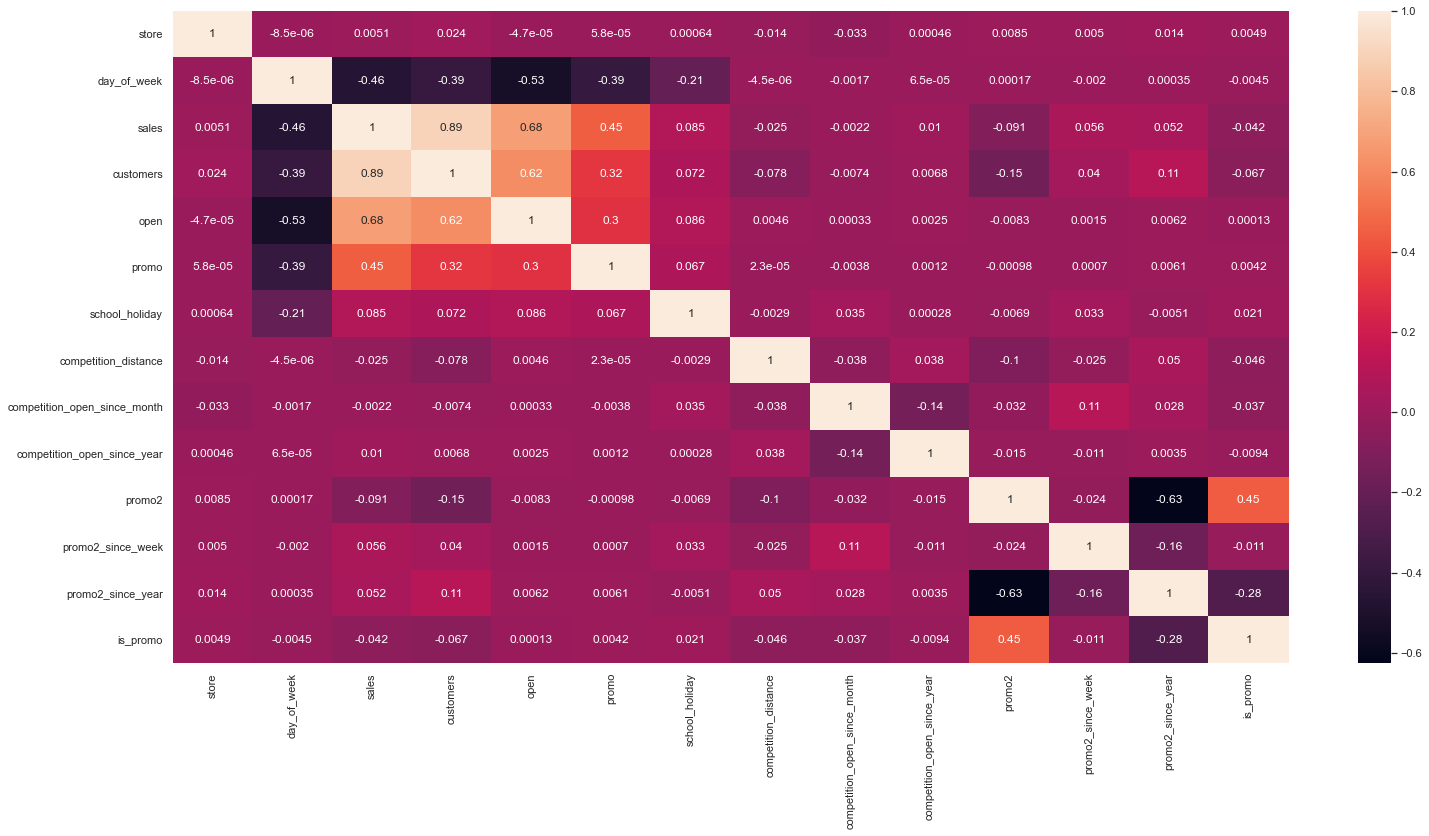

In [148]:
numerical_correlation = num_attributes.corr(method='pearson')
sns.heatmap(numerical_correlation, annot=True)

### 4.3.2. Categorical Attributes

In [149]:
a = df4.select_dtypes(include='object')

In [189]:

#calculando cramer_v
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame(
    {
    "state_holiday": [a1,a2,a3],
    "store_type": [a4,a5,a6],
    "assortment": [a7,a8,a9]
    }
)
d = d.set_index(d.columns)
d

,state_holiday,store_type,assortment
state_holiday,1.000002,0.071065,0.067546
store_type,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


<AxesSubplot:>

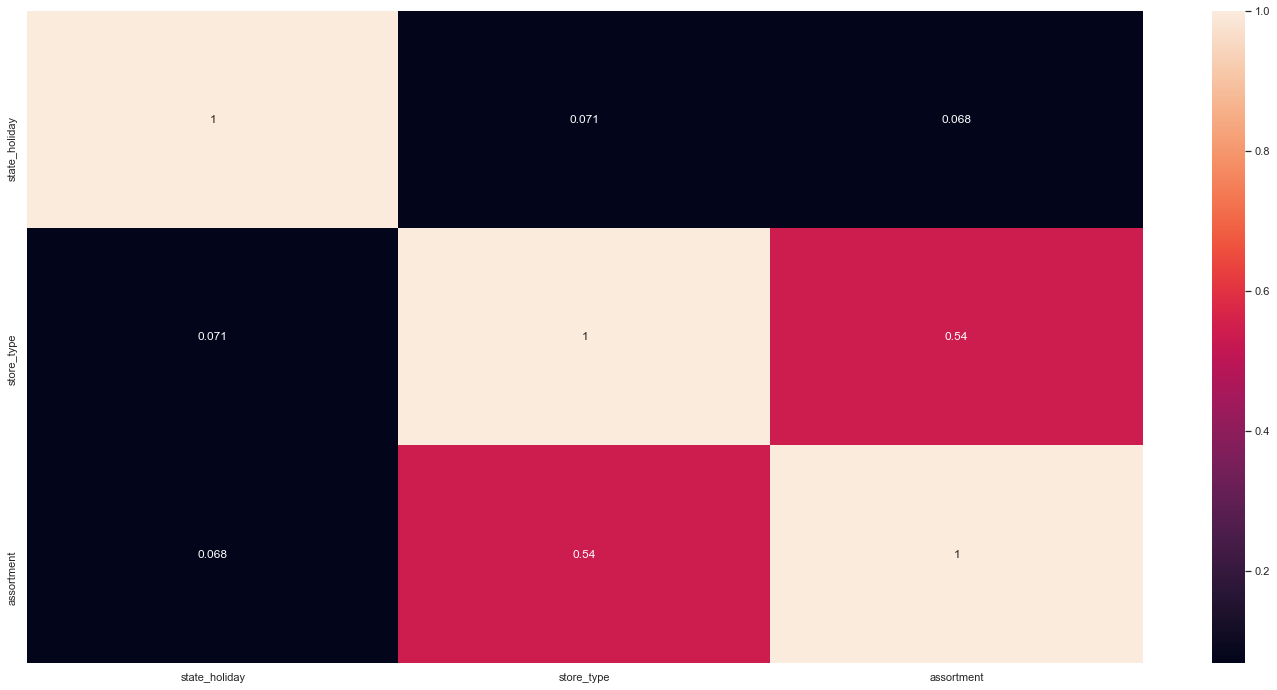

In [190]:
sns.heatmap(d, annot=True)